In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, mutual_info_regression, f_regression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

('Gradient Boosting', GradientBoostingRegressor(n_estimators=25, random_state=42, max_depth=4)),

In [3]:
# STAR rating dataset
data = pd.read_csv("School_STAR_Scores.csv")

# Convert school type to numerical data
schooltypes = set(data['School_Type'])
school_categories = {}
idx = 1
for cat in schooltypes:
  school_categories[cat] = idx
  idx += 1

# One-hot encode school type, since one-hot encoded features tended to be selected as best in the movie data in assignment 2
schools_list = list(schooltypes)
for schooltype in schools_list:
  data[schooltype] = 0

for i in range(len(data)):
  school_type = data.loc[i, 'School_Type']
  data.loc[i, school_type] = 1

star_data = data.drop(columns='School_Type')

print(star_data.shape) # there are 153 Distric of Columbia Public Schools in this set
star_data.head()

(203, 12)


,LEA_Code,LEA_Name,School_Code,School_Name,Ward,STAR_Score,STAR_Rating,ObjectId,DCPS (Alternative),DCPS,Charter,Charter (Alternative)
0,1,District of Columbia Public Schools,202,Aiton Elementary School,7,43.85,3,1,0,1,0,0
1,1,District of Columbia Public Schools,203,Amidon-Bowen Elementary School,6,36.53,2,2,0,1,0,0
2,1,District of Columbia Public Schools,450,Anacostia High School,8,2.85,1,3,0,1,0,0
3,1,District of Columbia Public Schools,474,Washington Metropolitan High School,1,24.88,2,4,1,0,0,0
4,1,District of Columbia Public Schools,452,Ballou High School,8,4.65,1,5,0,1,0,0


In [4]:
# Merge in the second DC OpenData dataset
more_data = pd.read_csv("DC_Public_Schools.csv")
print("DC Schools shape:", more_data.shape)

# Will want to join on school code, so leave that in
# Features to add: Year built, square footage, Capital Gains (this is a monetary behavior/attendance incentive for students),
# Facility type (for example, middle schools might have lower star ratings than high schools), total students, zip code

addl_features = more_data[['SCHOOL_ID', 'YEAR_BUILT', 'SQUARE_FOOTAGE', 'CAPITALGAINS', 'FACUSE', 'TOTAL_STUD', 'ZIPCODE']].copy()

# Convert capital gains to binary first
addl_features['CAPITALGAINS'] = addl_features['CAPITALGAINS'].replace({'N': 0, 'Y': 1})
addl_features['CAPITALGAINS'] = pd.to_numeric(addl_features['CAPITALGAINS'], errors='coerce')

# One-hot encode facility use before imputation
facilities = addl_features['FACUSE'].dropna().unique()
for fac_type in facilities:
    addl_features[fac_type] = (addl_features['FACUSE'] == fac_type).astype(int)

addl_features = addl_features.drop(columns='FACUSE')

# Apply KNN imputation to numerical columns
numeric_cols = ['YEAR_BUILT', 'SQUARE_FOOTAGE', 'TOTAL_STUD', 'ZIPCODE', 'CAPITALGAINS']
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
addl_features[numeric_cols] = knn_imputer.fit_transform(addl_features[numeric_cols])

# Convert to appropriate types
addl_features = addl_features.astype({'YEAR_BUILT': 'int64', 'TOTAL_STUD': 'int64', 'ZIPCODE': 'int64', 'CAPITALGAINS': 'int64'})
addl_features = addl_features.rename(columns={'SCHOOL_ID': 'School_Code'})

# Merge with existing data
baseline_data = star_data[['LEA_Code', 'School_Code', 'School_Name', 'Ward', 'STAR_Rating'] + schools_list]
full_data = baseline_data.merge(addl_features, on='School_Code', how='inner')

print("Star and DC schools merged shape:", full_data.shape)
full_data.head()

DC Schools shape: (123, 36)
Star and DC schools merged shape: (109, 24)


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\1521654187.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addl_features['CAPITALGAINS'] = addl_features['CAPITALGAINS'].replace({'N': 0, 'Y': 1})


,LEA_Code,School_Code,School_Name,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,...,Elementary School,Middle School,Youth Engagement,High School,High School/Specialized,Specialized School,Special Education,Education Campus,Elementary School/Specialized,Middle School/High School
0,1,202,Aiton Elementary School,7,3,0,1,0,0,1960,...,1,0,0,0,0,0,0,0,0,0
1,1,203,Amidon-Bowen Elementary School,6,2,0,1,0,0,1960,...,1,0,0,0,0,0,0,0,0,0
2,1,450,Anacostia High School,8,1,0,1,0,0,1935,...,0,0,0,1,0,0,0,0,0,0
3,1,452,Ballou High School,8,1,0,1,0,0,1960,...,0,0,0,1,0,0,0,0,0,0
4,1,204,Bancroft Elementary School @ Sharpe,1,4,0,1,0,0,1928,...,1,0,0,0,0,0,0,0,0,0


In [5]:
full_data.shape

(109, 24)

In [6]:
# Enrollment data (single year 2023-24)

enrollment_demos = pd.read_csv("dc_public_schools_enrollmentinfo.csv")

# Rename columns for easier use
enrollment_demos = enrollment_demos.rename(columns={
    'School Name': 'School_Name',
    'Black or African American Students [Public School] 2023-24': 'Black_Students',
    'Total Race/Ethnicity [Public School] 2023-24': 'Total_Reported_Race',
    'Hispanic Students [Public School] 2023-24': 'Hispanic_Students',
    'Asian or Asian/Pacific Islander Students [Public School] 2023-24': 'Asian_Students',
    'American Indian/Alaska Native Students [Public School] 2023-24': 'AmericanIndian_AlaskaNative_Students',
    'White Students [Public School] 2023-24': 'White_Students',
    'Nat. Hawaiian or Other Pacific Isl. Students [Public School] 2023-24': 'Hawaiian_PacificIslander_Students',
    'Two or More Races Students [Public School] 2023-24': 'MixedRace_Students',
    'Pupil/Teacher Ratio [Public School] 2023-24': 'Student_Teacher_Ratio',
    'Location ZIP [Public School] 2023-24': 'zipcode'
})

# Select relevant columns
enrollment_features = enrollment_demos[['School_Name', 'Black_Students', 'Total_Reported_Race', 'Hispanic_Students', 
                                        'Asian_Students', 'AmericanIndian_AlaskaNative_Students', 'White_Students', 
                                        'Hawaiian_PacificIslander_Students', 'MixedRace_Students', 'Student_Teacher_Ratio', 'zipcode']]

# Drop rows with missing school name
enrollment_features = enrollment_features.dropna(subset=['School_Name']).reset_index(drop=True)

# Update school name formatting for merging
enrollment_features['School_Name'] = enrollment_features['School_Name'].str.replace('ES', 'Elementary School')
enrollment_features['School_Name'] = enrollment_features['School_Name'].str.replace('MS', 'Middle School')
enrollment_features['School_Name'] = enrollment_features['School_Name'].str.replace('HS', 'High School')
enrollment_features['School_Name'] = enrollment_features['School_Name'].str.lower()

# Replace '–' with NaN for numeric columns
numeric_cols = ['Black_Students', 'Total_Reported_Race', 'Hispanic_Students', 'Asian_Students', 
                'AmericanIndian_AlaskaNative_Students', 'White_Students', 'Hawaiian_PacificIslander_Students', 
                'MixedRace_Students', 'Student_Teacher_Ratio']

for col in numeric_cols:
    enrollment_features[col] = enrollment_features[col].replace('–', np.nan)
    enrollment_features[col] = pd.to_numeric(enrollment_features[col], errors='coerce')

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
enrollment_features[numeric_cols] = knn_imputer.fit_transform(enrollment_features[numeric_cols])

print("Null columns:")
print(enrollment_features.isna().sum())
print("NA columns:")
print(enrollment_features.isnull().sum())

enrollment_features.head()

Null columns:
School_Name                             0
Black_Students                          0
Total_Reported_Race                     0
Hispanic_Students                       0
Asian_Students                          0
AmericanIndian_AlaskaNative_Students    0
White_Students                          0
Hawaiian_PacificIslander_Students       0
MixedRace_Students                      0
Student_Teacher_Ratio                   0
zipcode                                 4
dtype: int64
NA columns:
School_Name                             0
Black_Students                          0
Total_Reported_Race                     0
Hispanic_Students                       0
Asian_Students                          0
AmericanIndian_AlaskaNative_Students    0
White_Students                          0
Hawaiian_PacificIslander_Students       0
MixedRace_Students                      0
Student_Teacher_Ratio                   0
zipcode                                 4
dtype: int64


,School_Name,Black_Students,Total_Reported_Race,Hispanic_Students,Asian_Students,AmericanIndian_AlaskaNative_Students,White_Students,Hawaiian_PacificIslander_Students,MixedRace_Students,Student_Teacher_Ratio,zipcode
0,achievement preparatory academy pcs - wahler p...,304.0,323.0,10.0,0.0,2.0,0.0,0.0,7.0,13.69,20032.0
1,amidon-bowen elementary school,270.0,365.0,26.0,3.0,0.0,51.0,1.0,14.0,10.58,20024.0
2,anacostia high school,235.0,244.0,7.0,0.0,0.0,1.0,0.0,1.0,7.75,20020.0
3,appletree early learning center pcs - columbia...,86.0,123.0,27.0,4.0,0.0,5.0,0.0,1.0,9.04,20009.0
4,appletree early learning center pcs - douglas ...,47.0,51.0,2.0,1.0,1.0,0.0,0.0,0.0,42.50,20020.0


In [7]:
# Merge in the enrollment data
full_data['School_Name'] = full_data['School_Name'].str.lower()
full_data = full_data.merge(enrollment_features, on='School_Name', how='left')

print(full_data.shape)
full_data.head()

(109, 34)


,LEA_Code,School_Code,School_Name,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,...,Black_Students,Total_Reported_Race,Hispanic_Students,Asian_Students,AmericanIndian_AlaskaNative_Students,White_Students,Hawaiian_PacificIslander_Students,MixedRace_Students,Student_Teacher_Ratio,zipcode
0,1,202,aiton elementary school,7,3,0,1,0,0,1960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,203,amidon-bowen elementary school,6,2,0,1,0,0,1960,...,270.0,365.0,26.0,3.0,0.0,51.0,1.0,14.0,10.58,20024.0
2,1,450,anacostia high school,8,1,0,1,0,0,1935,...,235.0,244.0,7.0,0.0,0.0,1.0,0.0,1.0,7.75,20020.0
3,1,452,ballou high school,8,1,0,1,0,0,1960,...,567.0,585.0,16.0,0.0,1.0,0.0,0.0,1.0,9.70,20032.0
4,1,204,bancroft elementary school @ sharpe,1,4,0,1,0,0,1928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Apply KNN imputation to handle missing values from schools that didn't merge with enrollment data
# Identify columns that may have missing values after the left merge
cols_to_impute = ['Black_Students', 'Total_Reported_Race', 'Hispanic_Students', 'Asian_Students', 
                  'AmericanIndian_AlaskaNative_Students', 'White_Students', 'Hawaiian_PacificIslander_Students', 
                  'MixedRace_Students', 'Student_Teacher_Ratio', 'zipcode']

# Check for missing values
print("Missing values before KNN imputation:")
print(full_data[cols_to_impute].isna().sum())

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
full_data[cols_to_impute] = knn_imputer.fit_transform(full_data[cols_to_impute])

print("\nMissing values after KNN imputation:")
print(full_data[cols_to_impute].isna().sum())
print(f"\nFull data shape: {full_data.shape}")

Missing values before KNN imputation:
Black_Students                          25
Total_Reported_Race                     25
Hispanic_Students                       25
Asian_Students                          25
AmericanIndian_AlaskaNative_Students    25
White_Students                          25
Hawaiian_PacificIslander_Students       25
MixedRace_Students                      25
Student_Teacher_Ratio                   25
zipcode                                 25
dtype: int64

Missing values after KNN imputation:
Black_Students                          0
Total_Reported_Race                     0
Hispanic_Students                       0
Asian_Students                          0
AmericanIndian_AlaskaNative_Students    0
White_Students                          0
Hawaiian_PacificIslander_Students       0
MixedRace_Students                      0
Student_Teacher_Ratio                   0
zipcode                                 0
dtype: int64

Full data shape: (109, 34)


In [9]:
# Get funding data
# NOTE: Can't get more years of funding data because the NERDS website went under construction since I got the 2023-24 data.
funding_data = pd.read_csv("dc_schools_funding.csv")

funding_features = funding_data[['schoolid_stateassigned', 'schoolname', 'enroll_raw_DC', 'pp_fed_raw_DC', 'pp_total_raw_DC', 'pp_site_stloc_raw_DC', 'pp_site_fed_raw_DC', 'pp_site_raw_DC', 'flag_NERDS']]
funding_features = funding_features.rename(columns={'schoolid_stateassigned': 'School_Code', 'enroll_raw_DC': 'enrollment_for_funding_calcs_202324', 'pp_fed_raw_DC': 'per_student_fed_exp_202324', 'pp_total_raw_DC': 'per_student_total_exp_202324', 'pp_site_stloc_raw_DC': 'per_student_state_local_site_exp_202324', 'pp_site_fed_raw_DC': 'per_student_fed_site_exp_202324', 'pp_site_raw_DC': 'per_student_total_site_exp_202324'})
funding_features = funding_features[funding_features['flag_NERDS'] == 0] # Remove schools with flag for implausible financial data

# Check for missing data
print("Null columns:")
print(funding_features.isna().sum())
print("NA columns:")
print(funding_features.isnull().sum())
# Yay, no missing data!

print(funding_features.shape)
funding_features.head()

Null columns:
School_Code                                0
schoolname                                 0
enrollment_for_funding_calcs_202324        0
per_student_fed_exp_202324                 0
per_student_total_exp_202324               0
per_student_state_local_site_exp_202324    0
per_student_fed_site_exp_202324            0
per_student_total_site_exp_202324          0
flag_NERDS                                 0
dtype: int64
NA columns:
School_Code                                0
schoolname                                 0
enrollment_for_funding_calcs_202324        0
per_student_fed_exp_202324                 0
per_student_total_exp_202324               0
per_student_state_local_site_exp_202324    0
per_student_fed_site_exp_202324            0
per_student_total_site_exp_202324          0
flag_NERDS                                 0
dtype: int64
(228, 9)


,School_Code,schoolname,enrollment_for_funding_calcs_202324,per_student_fed_exp_202324,per_student_total_exp_202324,per_student_state_local_site_exp_202324,per_student_fed_site_exp_202324,per_student_total_site_exp_202324,flag_NERDS
0,233,Academy of Hope Adult PCS,840.0,741.8988095,15774.42619,15032.52738,741.8988095,15774.42619,0
1,217,Achievement Preparatory Academy PCS - Wahler P...,323.0,4264.958452,37142.91582,32877.95737,4264.958452,37142.91582,0
2,140,AppleTree Early Learning Center PCS - Columbia...,123.0,3437.260163,29339.6748,20300.97561,3437.260163,23738.23577,0
3,3072,AppleTree Early Learning Center PCS - Douglas ...,51.0,3669.176471,30153.19608,20882.58824,3669.176471,24551.76471,0
4,3073,AppleTree Early Learning Center PCS - Lincoln ...,59.0,2772.135593,28109.67797,19736.10169,2772.135593,22508.23729,0


In [10]:
# Merge in the funding data
full_data = full_data.merge(funding_features, on='School_Code', how='inner')

print(full_data.shape) # 83 rows--lost 6 schools in the merge
full_data = full_data.drop(columns=['schoolname', 'flag_NERDS']) # Don't need two schoolname columns--the additional column was to make sure the school code merge worked as intended. Also don't need flag_NERDS anymore
full_data.head()

(103, 42)


,LEA_Code,School_Code,School_Name,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,...,Hawaiian_PacificIslander_Students,MixedRace_Students,Student_Teacher_Ratio,zipcode,enrollment_for_funding_calcs_202324,per_student_fed_exp_202324,per_student_total_exp_202324,per_student_state_local_site_exp_202324,per_student_fed_site_exp_202324,per_student_total_site_exp_202324
0,1,202,aiton elementary school,7,3,0,1,0,0,1960,...,0.190476,13.083333,11.369643,20014.011905,146.0,5569.603767,39569.79363,28335.25863,1975.663288,30310.92192
1,1,203,amidon-bowen elementary school,6,2,0,1,0,0,1960,...,1.000000,14.000000,10.580000,20024.000000,365.0,4401.45926,25726.59022,15660.19973,807.5187945,16467.71852
2,1,452,ballou high school,8,1,0,1,0,0,1960,...,0.000000,1.000000,9.700000,20032.000000,585.0,4746.675026,34587.49711,24175.89084,1152.734564,25328.6254
3,1,204,bancroft elementary school @ sharpe,1,4,0,1,0,0,1928,...,0.190476,13.083333,11.369643,20014.011905,768.0,3837.150977,25510.76656,16008.68435,243.2105208,16251.89487
4,1,205,barnard elementary school,4,4,0,1,0,0,2003,...,0.000000,17.000000,10.550000,20011.000000,591.0,4330.699763,27232.57239,17236.94139,736.7593063,17973.70069


In [11]:
full_data.columns

Index(['LEA_Code', 'School_Code', 'School_Name', 'Ward', 'STAR_Rating',
       'DCPS (Alternative)', 'DCPS', 'Charter', 'Charter (Alternative)',
       'YEAR_BUILT', 'SQUARE_FOOTAGE', 'CAPITALGAINS', 'TOTAL_STUD', 'ZIPCODE',
       'Elementary School', 'Middle School', 'Youth Engagement', 'High School',
       'High School/Specialized', 'Specialized School', 'Special Education',
       'Education Campus', 'Elementary School/Specialized',
       'Middle School/High School', 'Black_Students', 'Total_Reported_Race',
       'Hispanic_Students', 'Asian_Students',
       'AmericanIndian_AlaskaNative_Students', 'White_Students',
       'Hawaiian_PacificIslander_Students', 'MixedRace_Students',
       'Student_Teacher_Ratio', 'zipcode',
       'enrollment_for_funding_calcs_202324', 'per_student_fed_exp_202324',
       'per_student_total_exp_202324',
       'per_student_state_local_site_exp_202324',
       'per_student_fed_site_exp_202324', 'per_student_total_site_exp_202324'],
      dtype='obj

In [12]:
# Get DC ward data
# This is 5 year data, so no need to get more years
ward_data = pd.read_csv('dc_wards_demo_data.csv')
ward_data = ward_data.rename(columns={'Current name': 'Ward', 'HISPANIC OR LATINO AND RACE:  Total population': 'ward_total_pop', 'HISPANIC OR LATINO AND RACE:  Total population:  Hispanic or Latino (of any race)': 'ward_hispanic_latino', 'HISPANIC OR LATINO AND RACE:  Total population:  Not Hispanic or Latino:  American Indian and Alaska Native alone': 'ward_americanindian_alaskanative', 'HISPANIC OR LATINO AND RACE:  Total population:  Not Hispanic or Latino:  Asian alone': 'ward_asian', 'HISPANIC OR LATINO AND RACE:  Total population:  Not Hispanic or Latino:  Black or African American alone': 'ward_black', 'HISPANIC OR LATINO AND RACE:  Total population:  Not Hispanic or Latino:  Native Hawaiian and Other Pacific Islander alone': 'ward_hawaiian_pacific_islander', 'HISPANIC OR LATINO AND RACE:  Total population:  Not Hispanic or Latino:  White alone': 'ward_white'})
ward_features = ward_data[['Ward', 'ward_total_pop', 'ward_hispanic_latino', 'ward_americanindian_alaskanative', 'ward_asian', 'ward_black', 'ward_hawaiian_pacific_islander', 'ward_white']]

for i in range(len(ward_features)):
  ward = ward_features.loc[i, 'Ward']
  # Update ward formatting to enable merging with existing data
  ward = ward.replace('Ward ', '')
  ward = int(ward)
  ward_features.loc[i, 'Ward'] = ward

print("Null columns:")
print(ward_features.isna().sum())
print("NA columns:")
print(ward_features.isnull().sum())
# Yay, no missing data!

ward_features.head(10)

Null columns:
Ward                                0
ward_total_pop                      0
ward_hispanic_latino                0
ward_americanindian_alaskanative    0
ward_asian                          0
ward_black                          0
ward_hawaiian_pacific_islander      0
ward_white                          0
dtype: int64
NA columns:
Ward                                0
ward_total_pop                      0
ward_hispanic_latino                0
ward_americanindian_alaskanative    0
ward_asian                          0
ward_black                          0
ward_hawaiian_pacific_islander      0
ward_white                          0
dtype: int64


,Ward,ward_total_pop,ward_hispanic_latino,ward_americanindian_alaskanative,ward_asian,ward_black,ward_hawaiian_pacific_islander,ward_white
0,2,"78,878","10,935",91,"7,287","8,004",121,"48,550"
1,4,"85,587","18,003",105,"1,588","39,137",44,"22,067"
2,7,"90,898","6,358",168,604,"73,378",0,"6,182"
3,1,"79,373","15,867",130,"4,731","17,359",89,"36,328"
4,8,"86,509","3,390",106,909,"70,376",21,"7,906"
5,6,"84,004","7,150",15,"3,715","19,915",22,"48,605"
6,3,"78,404","7,308",4,"5,299","6,851",0,"54,431"
7,5,"88,426","8,749",96,"2,837","50,906",0,"21,691"


In [13]:
# Merge in the ward demo data
full_data = full_data.merge(ward_features, on='Ward', how='inner')

print(full_data.shape) # 390 rows
print(full_data.dtypes)

full_data.head()

(103, 47)
LEA_Code                                     int64
School_Code                                  int64
School_Name                                 object
Ward                                        object
STAR_Rating                                  int64
DCPS (Alternative)                           int64
DCPS                                         int64
Charter                                      int64
Charter (Alternative)                        int64
YEAR_BUILT                                   int64
SQUARE_FOOTAGE                             float64
CAPITALGAINS                                 int64
TOTAL_STUD                                   int64
ZIPCODE                                      int64
Elementary School                            int64
Middle School                                int64
Youth Engagement                             int64
High School                                  int64
High School/Specialized                      int64
Specialized School   

,LEA_Code,School_Code,School_Name,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,...,per_student_state_local_site_exp_202324,per_student_fed_site_exp_202324,per_student_total_site_exp_202324,ward_total_pop,ward_hispanic_latino,ward_americanindian_alaskanative,ward_asian,ward_black,ward_hawaiian_pacific_islander,ward_white
0,1,202,aiton elementary school,7,3,0,1,0,0,1960,...,28335.25863,1975.663288,30310.92192,"90,898","6,358",168,604,"73,378",0,"6,182"
1,1,203,amidon-bowen elementary school,6,2,0,1,0,0,1960,...,15660.19973,807.5187945,16467.71852,"84,004","7,150",15,"3,715","19,915",22,"48,605"
2,1,452,ballou high school,8,1,0,1,0,0,1960,...,24175.89084,1152.734564,25328.6254,"86,509","3,390",106,909,"70,376",21,"7,906"
3,1,204,bancroft elementary school @ sharpe,1,4,0,1,0,0,1928,...,16008.68435,243.2105208,16251.89487,"79,373","15,867",130,"4,731","17,359",89,"36,328"
4,1,205,barnard elementary school,4,4,0,1,0,0,2003,...,17236.94139,736.7593063,17973.70069,"85,587","18,003",105,"1,588","39,137",44,"22,067"


In [14]:
# Get economic characteristics by ward
econ_ward_data = pd.read_csv('economic_characteristics_dc_wards.csv')
econ_ward_data = econ_ward_data.rename(columns={'NAMELSAD': 'Ward', 'DP03_0062E': 'median_household_income'})
econ_ward_features = econ_ward_data[['Ward', 'median_household_income']]

for i in range(len(ward_features)):
  ward = econ_ward_features.loc[i, 'Ward']
  # Update ward formatting to enable merging with existing data
  ward = ward.replace('Ward ', '')
  ward = int(ward)
  econ_ward_features.loc[i, 'Ward'] = ward

print("Null columns:")
print(econ_ward_features.isna().sum())
print("NA columns:")
print(econ_ward_features.isnull().sum())
# Yay, no missing data!

econ_ward_features.head(10)

Null columns:
Ward                       0
median_household_income    0
dtype: int64
NA columns:
Ward                       0
median_household_income    0
dtype: int64


,Ward,median_household_income
0,2,131405
1,4,128210
2,7,69109
3,1,126387
4,8,50931
5,6,138047
6,3,141849
7,5,97814


In [15]:
# Merge in the economic characteristics data
full_data = full_data.merge(econ_ward_features, on='Ward', how='inner')

print(full_data.shape) # 390 rows
print(full_data.dtypes)

full_data.head()

(103, 48)
LEA_Code                                     int64
School_Code                                  int64
School_Name                                 object
Ward                                        object
STAR_Rating                                  int64
DCPS (Alternative)                           int64
DCPS                                         int64
Charter                                      int64
Charter (Alternative)                        int64
YEAR_BUILT                                   int64
SQUARE_FOOTAGE                             float64
CAPITALGAINS                                 int64
TOTAL_STUD                                   int64
ZIPCODE                                      int64
Elementary School                            int64
Middle School                                int64
Youth Engagement                             int64
High School                                  int64
High School/Specialized                      int64
Specialized School   

,LEA_Code,School_Code,School_Name,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,...,per_student_fed_site_exp_202324,per_student_total_site_exp_202324,ward_total_pop,ward_hispanic_latino,ward_americanindian_alaskanative,ward_asian,ward_black,ward_hawaiian_pacific_islander,ward_white,median_household_income
0,1,202,aiton elementary school,7,3,0,1,0,0,1960,...,1975.663288,30310.92192,"90,898","6,358",168,604,"73,378",0,"6,182",69109
1,1,203,amidon-bowen elementary school,6,2,0,1,0,0,1960,...,807.5187945,16467.71852,"84,004","7,150",15,"3,715","19,915",22,"48,605",138047
2,1,452,ballou high school,8,1,0,1,0,0,1960,...,1152.734564,25328.6254,"86,509","3,390",106,909,"70,376",21,"7,906",50931
3,1,204,bancroft elementary school @ sharpe,1,4,0,1,0,0,1928,...,243.2105208,16251.89487,"79,373","15,867",130,"4,731","17,359",89,"36,328",126387
4,1,205,barnard elementary school,4,4,0,1,0,0,2003,...,736.7593063,17973.70069,"85,587","18,003",105,"1,588","39,137",44,"22,067",128210


# Step 2: Exploratory data analysis, feature engineering, and feature selection

---



In [16]:
pd.set_option('display.max_columns', None)

print("Null columns:")
print(full_data.isna().sum())


Null columns:
LEA_Code                                   0
School_Code                                0
School_Name                                0
Ward                                       0
STAR_Rating                                0
DCPS (Alternative)                         0
DCPS                                       0
Charter                                    0
Charter (Alternative)                      0
YEAR_BUILT                                 0
SQUARE_FOOTAGE                             0
CAPITALGAINS                               0
TOTAL_STUD                                 0
ZIPCODE                                    0
Elementary School                          0
Middle School                              0
Youth Engagement                           0
High School                                0
High School/Specialized                    0
Specialized School                         0
Special Education                          0
Education Campus                         

In [17]:
# Variable for complete dataset: full_data
# Do we need to make a bunch of plots of the data like in assignment 2?
# TODO: Do we need to exclude a variable from each category?

# Drop ZIPCODE, since it's the same as zipcode but had some missing/imputed observations
full_data = full_data.drop(columns=['ZIPCODE'])

# Give the two enrollment variables more descriptive names
full_data = full_data.rename(columns={'TOTAL_STUD': '2025_enrollment', 'enrollment_for_funding_calcs_202324': '2024_enrollment_for_funding_calcs'})
print(full_data.dtypes)
full_data[['2025_enrollment', '2024_enrollment_for_funding_calcs']].head()


LEA_Code                                     int64
School_Code                                  int64
School_Name                                 object
Ward                                        object
STAR_Rating                                  int64
DCPS (Alternative)                           int64
DCPS                                         int64
Charter                                      int64
Charter (Alternative)                        int64
YEAR_BUILT                                   int64
SQUARE_FOOTAGE                             float64
CAPITALGAINS                                 int64
2025_enrollment                              int64
Elementary School                            int64
Middle School                                int64
Youth Engagement                             int64
High School                                  int64
High School/Specialized                      int64
Specialized School                           int64
Special Education              

,2025_enrollment,2024_enrollment_for_funding_calcs
0,269,146.0
1,254,365.0
2,910,585.0
3,463,768.0
4,482,591.0


In [18]:
# Now we can drop school name, school code, and LEA code, since these are not very informative on their own in terms of STAR rating
full_data = full_data.drop(columns=['School_Name', 'School_Code', 'LEA_Code'])

# Convert any strings in numerical columns to ints
cols = ['ward_total_pop', 'ward_hispanic_latino', 'ward_americanindian_alaskanative', 'ward_asian', 'ward_black', 'ward_hawaiian_pacific_islander', 'ward_white']
for i in range(len(full_data)):
  for col in cols:
    val = full_data.loc[i, col]
    if type(val) == str:
      val = val.replace(',', '')
      val = int(val)
      full_data.loc[i, col] = val
    elif type(val) != int:
      val = int(val)
      full_data.loc[i, col] = val


full_data.head()

,Ward,STAR_Rating,DCPS (Alternative),DCPS,Charter,Charter (Alternative),YEAR_BUILT,SQUARE_FOOTAGE,CAPITALGAINS,2025_enrollment,Elementary School,Middle School,Youth Engagement,High School,High School/Specialized,Specialized School,Special Education,Education Campus,Elementary School/Specialized,Middle School/High School,Black_Students,Total_Reported_Race,Hispanic_Students,Asian_Students,AmericanIndian_AlaskaNative_Students,White_Students,Hawaiian_PacificIslander_Students,MixedRace_Students,Student_Teacher_Ratio,zipcode,2024_enrollment_for_funding_calcs,per_student_fed_exp_202324,per_student_total_exp_202324,per_student_state_local_site_exp_202324,per_student_fed_site_exp_202324,per_student_total_site_exp_202324,ward_total_pop,ward_hispanic_latino,ward_americanindian_alaskanative,ward_asian,ward_black,ward_hawaiian_pacific_islander,ward_white,median_household_income
0,7,3,0,1,0,0,1960,57100.000000,0,269,1,0,0,0,0,0,0,0,0,0,266.833333,459.595238,102.785714,8.071429,0.440476,68.190476,0.190476,13.083333,11.369643,20014.011905,146.0,5569.603767,39569.79363,28335.25863,1975.663288,30310.92192,90898,6358,168,604,73378,0,6182,69109
1,6,2,0,1,0,0,1960,70800.000000,0,254,1,0,0,0,0,0,0,0,0,0,270.000000,365.000000,26.000000,3.000000,0.000000,51.000000,1.000000,14.000000,10.580000,20024.000000,365.0,4401.45926,25726.59022,15660.19973,807.5187945,16467.71852,84004,7150,15,3715,19915,22,48605,138047
2,8,1,0,1,0,0,1960,271300.000000,0,910,0,0,0,1,0,0,0,0,0,0,567.000000,585.000000,16.000000,0.000000,1.000000,0.000000,0.000000,1.000000,9.700000,20032.000000,585.0,4746.675026,34587.49711,24175.89084,1152.734564,25328.6254,86509,3390,106,909,70376,21,7906,50931
3,1,4,0,1,0,0,1928,107954.277215,0,463,1,0,0,0,0,0,0,0,0,0,266.833333,459.595238,102.785714,8.071429,0.440476,68.190476,0.190476,13.083333,11.369643,20014.011905,768.0,3837.150977,25510.76656,16008.68435,243.2105208,16251.89487,79373,15867,130,4731,17359,89,36328,126387
4,4,4,0,1,0,0,2003,154625.843496,0,482,1,0,0,0,0,0,0,0,0,0,243.000000,591.000000,268.000000,3.000000,0.000000,60.000000,0.000000,17.000000,10.550000,20011.000000,591.0,4330.699763,27232.57239,17236.94139,736.7593063,17973.70069,85587,18003,105,1588,39137,44,22067,128210


In [19]:
# Convert race columns into percentages

# School Enrollment - these are already numeric from the earlier cleaning
race_col_list = ['Black_Students', 'Hispanic_Students', 'Asian_Students', 'AmericanIndian_AlaskaNative_Students', 'White_Students', 'Hawaiian_PacificIslander_Students', 'MixedRace_Students']
for race_col in race_col_list:
  full_data[race_col] = full_data[race_col] / full_data['Total_Reported_Race']
  new_col_name = 'Pct_' + race_col # rename
  full_data.rename(columns = {race_col: new_col_name}, inplace = True)

In [20]:
# Convert race columns into percentages

# Wards
race_col_list = ['ward_hispanic_latino', 'ward_americanindian_alaskanative', 'ward_asian', 'ward_black', 'ward_hawaiian_pacific_islander', 'ward_white']
for race_col in race_col_list:
  full_data[race_col] = full_data[race_col].astype('int64')
  full_data[race_col] = full_data[race_col] / full_data['ward_total_pop']
  new_col_name = 'pct_' + race_col # rename
  full_data.rename(columns = {race_col: new_col_name}, inplace = True)

In [21]:
# Convert per student total exp to a float so it can be used as the target variable

full_data['per_student_total_exp_202324'] = full_data['per_student_total_exp_202324'].astype(float)

In [22]:
# Drop other funding variables so that feature selection won't pick them up (they are highly correlated with the target variable, but don't really provide good info for our use case)
full_data = full_data.drop(columns=['per_student_fed_exp_202324', 'per_student_state_local_site_exp_202324', 'per_student_fed_site_exp_202324', 'per_student_total_site_exp_202324'])

In [23]:
# Drop 'DCPS' because it should be the base group (charter schools would be the comparison groups)--we want to avoid collinearity
# Drop 'Middle School/High School' to avoid collinearity and because it's redundant

full_data = full_data.drop(columns=['DCPS', 'Middle School/High School'])

In [24]:
# Cut down the number of variables using PCA
school_type_dummies = ['Charter (Alternative)', 'DCPS (Alternative)', 'Charter', 'High School', 'High School/Specialized',
                       'Special Education', 'Youth Engagement', 'Elementary School', 'Specialized School', 'Education Campus', 'Elementary School/Specialized', 'Middle School']

pca = sklearn.decomposition.PCA(n_components=3)
pca_schooltype = pca.fit_transform(full_data[school_type_dummies])
pca_schooltype = pd.DataFrame(pca_schooltype, columns=['SCHOOLTYPE1', 'SCHOOLTYPE2', 'SCHOOLTYPE3'])
full_data_no_pca = full_data.copy()
full_data = full_data.drop(columns=school_type_dummies)
full_data = pd.concat([full_data, pca_schooltype], axis=1)
print(full_data.shape) # Down to 29 columns
full_data.head()

(103, 29)


,Ward,STAR_Rating,YEAR_BUILT,SQUARE_FOOTAGE,CAPITALGAINS,2025_enrollment,Pct_Black_Students,Total_Reported_Race,Pct_Hispanic_Students,Pct_Asian_Students,Pct_AmericanIndian_AlaskaNative_Students,Pct_White_Students,Pct_Hawaiian_PacificIslander_Students,Pct_MixedRace_Students,Student_Teacher_Ratio,zipcode,2024_enrollment_for_funding_calcs,per_student_total_exp_202324,ward_total_pop,pct_ward_hispanic_latino,pct_ward_americanindian_alaskanative,pct_ward_asian,pct_ward_black,pct_ward_hawaiian_pacific_islander,pct_ward_white,median_household_income,SCHOOLTYPE1,SCHOOLTYPE2,SCHOOLTYPE3
0,7,3,1960,57100.000000,0,269,0.580583,459.595238,0.223644,0.017562,0.000958,0.148371,0.000414,0.028467,11.369643,20014.011905,146.0,39569.79363,90898,0.069947,0.001848,0.006645,0.807256,0.0,0.06801,69109,0.385985,0.031905,0.004823
1,6,2,1960,70800.000000,0,254,0.739726,365.000000,0.071233,0.008219,0.000000,0.139726,0.002740,0.038356,10.580000,20024.000000,365.0,25726.59022,84004,0.085115,0.000179,0.044224,0.237072,0.000262,0.578603,138047,0.385985,0.031905,0.004823
2,8,1,1960,271300.000000,0,910,0.969231,585.000000,0.027350,0.000000,0.001709,0.000000,0.000000,0.001709,9.700000,20032.000000,585.0,34587.49711,86509,0.039187,0.001225,0.010508,0.813511,0.000243,0.091389,50931,-0.654812,-0.586003,0.732042
3,1,4,1928,107954.277215,0,463,0.580583,459.595238,0.223644,0.017562,0.000958,0.148371,0.000414,0.028467,11.369643,20014.011905,768.0,25510.76656,79373,0.199904,0.001638,0.059605,0.218702,0.001121,0.457687,126387,0.385985,0.031905,0.004823
4,4,4,2003,154625.843496,0,482,0.411168,591.000000,0.453469,0.005076,0.000000,0.101523,0.000000,0.028765,10.550000,20011.000000,591.0,27232.57239,85587,0.210347,0.001227,0.018554,0.457277,0.000514,0.257831,128210,0.385985,0.031905,0.004823


In [29]:
# Use the feature selection permutations tried in the previous section, and then train the model

features = full_data.drop(columns=['per_student_total_exp_202324'])
target = full_data['per_student_total_exp_202324']

sfs_10 = SequentialFeatureSelector(RandomForestRegressor(n_estimators=10), n_features_to_select=10, direction='backward')
sfs_5 = SequentialFeatureSelector(RandomForestRegressor(n_estimators=10), n_features_to_select=5, direction='backward')
k_best_10 = SelectKBest(k=10, score_func=mutual_info_regression)
k_best_5 = SelectKBest(k=5, score_func=mutual_info_regression)

scalers = [StandardScaler(), MinMaxScaler()]
feature_selection = [k_best_10, k_best_5, sfs_10, sfs_5]

for scaler in scalers:
  for feature_select in feature_selection:
    pipeline = Pipeline([('preprocessing', scaler), ('feature_selection', feature_select)])
    winning_features = pipeline.fit(features, target).get_feature_names_out()
    print(f"NEW RUN: Scaler={scaler}, FeatureSelection={feature_select}")
    print("Winning features: ")
    print(winning_features)

NEW RUN: Scaler=StandardScaler(), FeatureSelection=SelectKBest(score_func=<function mutual_info_regression at 0x000001E81C019080>)
Winning features: 
['Ward' 'STAR_Rating' 'Total_Reported_Race' 'Pct_MixedRace_Students'
 '2024_enrollment_for_funding_calcs' 'ward_total_pop'
 'pct_ward_americanindian_alaskanative' 'pct_ward_asian' 'pct_ward_white'
 'median_household_income']
NEW RUN: Scaler=StandardScaler(), FeatureSelection=SelectKBest(k=5,
            score_func=<function mutual_info_regression at 0x000001E81C019080>)
Winning features: 
['Ward' '2024_enrollment_for_funding_calcs' 'ward_total_pop'
 'pct_ward_americanindian_alaskanative' 'median_household_income']
NEW RUN: Scaler=StandardScaler(), FeatureSelection=SequentialFeatureSelector(direction='backward',
                          estimator=RandomForestRegressor(n_estimators=10),
                          n_features_to_select=10)
Winning features: 
['Ward' '2025_enrollment' 'Pct_Hispanic_Students'
 'Pct_AmericanIndian_AlaskaNative_S

# Step 3: Full pipeline with feature engineering, feature selection, and model training

In [ ]:
# Create sklearn Pipeline to train the model with some different feature engineering and feature selection strategies

features = full_data.drop(columns=['per_student_total_exp_202324'])
target = full_data['per_student_total_exp_202324']

sfs_10 = SequentialFeatureSelector(RandomForestRegressor(n_estimators=10), n_features_to_select=10, direction='backward')
sfs_5 = SequentialFeatureSelector(RandomForestRegressor(n_estimators=10), n_features_to_select=5, direction='backward')
k_best_10 = SelectKBest(k=10, score_func=mutual_info_regression)
k_best_5 = SelectKBest(k=5, score_func=mutual_info_regression)

scalers = [StandardScaler()]
feature_selection = [k_best_10, k_best_5, sfs_10, sfs_5]

models = [RandomForestRegressor(n_estimators=10)] # Increase regularization param to help with overfitting

for scaler in scalers:
  for feature_select in feature_selection:
    for model in models:
      pipeline = Pipeline([('preprocessing', scaler), ('feature_selection', feature_select), ('estimator', model)])
      winning_features = pipeline[:-1].fit(features, target).get_feature_names_out()
      scores = cross_validate(pipeline, features, target, return_train_score=True, cv=5) # 5 folds
      test_r2 = scores['test_score']
      train_r2 = scores['train_score']
      avg_train_r2 = sum(train_r2) / len(train_r2)
      avg_test_r2 = sum(test_r2) / len(test_r2)
      overall_r2 = sum([avg_train_r2, avg_test_r2]) / 2
      print(f"NEW RUN: Scaler={scaler}, FeatureSelection={feature_select}, model={model}")
      print("Winning features: ", winning_features)
      print("Test R^2 values: ", test_r2)
      print("Avg test R^2: ", avg_test_r2)
      print("Train R^2: ", train_r2)
      print("Avg train R^2: ", avg_train_r2)
      print("Overall R^2: ", overall_r2)

NEW RUN: Scaler=StandardScaler(), FeatureSelection=SelectKBest(score_func=<function mutual_info_regression at 0x000001E81C019080>), model=RandomForestRegressor(n_estimators=10)
Winning features:  ['Ward' 'STAR_Rating' 'Total_Reported_Race' 'Pct_MixedRace_Students'
 'zipcode' '2024_enrollment_for_funding_calcs' 'ward_total_pop'
 'pct_ward_americanindian_alaskanative' 'pct_ward_asian'
 'median_household_income']
Test R^2 values:  [ 0.33997416 -0.3559296   0.36414873  0.51779029 -0.31651453]
Avg test R^2:  0.10989380811614897
Train R^2:  [0.90358876 0.8309851  0.88071033 0.88613779 0.89790537]
Avg train R^2:  0.8798654705066907
Overall R^2:  0.49487963931141987
NEW RUN: Scaler=StandardScaler(), FeatureSelection=SelectKBest(score_func=<function mutual_info_regression at 0x000001E81C019080>), model=RandomForestRegressor(n_estimators=15)
Winning features:  ['Ward' 'STAR_Rating' 'Total_Reported_Race' 'Pct_MixedRace_Students'
 '2024_enrollment_for_funding_calcs' 'ward_total_pop'
 'pct_ward_ame

# Model Optimization

Let's try additional strategies to improve test R² performance:

In [43]:
# Import additional models and tools
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

features = full_data.drop(columns=['per_student_total_exp_202324'])
target = full_data['per_student_total_exp_202324']



# Try different models with optimal feature selection (SFS with 10 features based on previous results)
scaler = MinMaxScaler()
feature_select = SequentialFeatureSelector(
    RandomForestRegressor(n_estimators=10, random_state=42), 
    n_features_to_select=10, 
    direction='backward'
)

# Models to test with random_state for reproducibility
models = [
    #('Random Forest (10)', RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10)),
    #('Random Forest (15)', RandomForestRegressor(n_estimators=15, random_state=42, max_depth=10)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=25, random_state=42, max_depth=4)),

]

results = []

for name, model in models:
    pipeline = Pipeline([
        ('preprocessing', scaler), 
        ('feature_selection', feature_select), 
        ('estimator', model)
    ])
    
    
    scores = cross_validate(pipeline, features, target, return_train_score=True, cv=5)
    test_r2 = scores['test_score']
    train_r2 = scores['train_score']
    avg_train_r2 = train_r2.mean()
    avg_test_r2 = test_r2.mean()
    
    results.append({
        'Model': name,
        'Avg Train R²': avg_train_r2,
        'Avg Test R²': avg_test_r2,
        'Test R² Std': test_r2.std(),
        'Overfitting Gap': avg_train_r2 - avg_test_r2
    })
    
    print(f"\n{name}")
    print(f"  Train R²: {avg_train_r2:.4f}")
    print(f"  Test R²: {avg_test_r2:.4f} (±{test_r2.std():.4f})")
    print(f"  Overfitting Gap: {avg_train_r2 - avg_test_r2:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Avg Test R²', ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

KeyboardInterrupt: 

In [39]:
from sklearn.model_selection import train_test_split

# Step 1: Make pipeline with only preprocessing and model (no feature selection since we should already know which features work, retrain and verify performance metrics)
# We are basically just re-creating the best performing model from the previous step
# TODO: Change these features as we improve the model
important_features = ['STAR_Rating', 'CAPITALGAINS', 'Total_Reported_Race', 'Pct_Hispanic_Students', 'ward_total_pop', 'pct_ward_hispanic_latino', 'pct_ward_americanindian_alaskanative', 'median_household_income', 'SCHOOLTYPE2', 'SCHOOLTYPE3']

features = full_data[important_features]
target = full_data['per_student_total_exp_202324']

# TODO: Change this as we improve the model
scaler = StandardScaler()

# TODO: Change this as we improve the model
model = RandomForestRegressor(n_estimators=15)

pipeline = Pipeline([('preprocessing', scaler), ('estimator', model)])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Cross validation
pipeline = pipeline.fit(X_train, y_train)
print(f"FINAL MODEL PERFORMANCE (Scaler={scaler}, features={important_features}, model={model})")
print("Training score: ", pipeline.score(X_train, y_train))
print("Test score: ", pipeline.score(X_test, y_test))
scores = cross_validate(pipeline, features, target, return_train_score=True, cv=5) # 5 folds
test_r2 = scores['test_score']
train_r2 = scores['train_score']
avg_train_r2 = sum(train_r2) / len(train_r2)
avg_test_r2 = sum(test_r2) / len(test_r2)
overall_r2 = sum([avg_train_r2, avg_test_r2]) / 2
print("CROSS VALIDATION SCORES")
print("Test R^2 values: ", test_r2)
print("Avg test R^2: ", avg_test_r2)
print("Train R^2: ", train_r2)
print("Avg train R^2: ", avg_train_r2)
print("Overall R^2: ", overall_r2)

FINAL MODEL PERFORMANCE (Scaler=StandardScaler(), features=['STAR_Rating', 'CAPITALGAINS', 'Total_Reported_Race', 'Pct_Hispanic_Students', 'ward_total_pop', 'pct_ward_hispanic_latino', 'pct_ward_americanindian_alaskanative', 'median_household_income', 'SCHOOLTYPE2', 'SCHOOLTYPE3'], model=RandomForestRegressor(n_estimators=15))
Training score:  0.7952105264931587
Test score:  0.4920523397362494
CROSS VALIDATION SCORES
Test R^2 values:  [ 0.04949388  0.12795589 -0.07024523  0.35565417  0.0975774 ]
Avg test R^2:  0.11208722116999532
Train R^2:  [0.8665877  0.8069335  0.88477857 0.79464463 0.80478331]
Avg train R^2:  0.8315455420058804
Overall R^2:  0.47181638158793787


In [32]:
# Try hyperparameter tuning on the best model
print("Hyperparameter Tuning for Random Forest...")

param_grid = {
    'estimator__n_estimators': [10, 15, 20, 25],
    'estimator__max_depth': [5, 8, 10, 12],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

base_pipeline = Pipeline([
    ('preprocessing', MinMaxScaler()),
    ('feature_selection', SequentialFeatureSelector(
        RandomForestRegressor(n_estimators=10, random_state=42), 
        n_features_to_select=10, 
        direction='backward'
    )),
    ('estimator', RandomForestRegressor(random_state=42))
])

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    base_pipeline, 
    param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(features, target)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation R²: {grid_search.best_score_:.4f}")

# Test the best model
best_model = grid_search.best_estimator_
scores = cross_validate(best_model, features, target, return_train_score=True, cv=5)
print(f"\nBest Model Performance:")
print(f"  Train R²: {scores['train_score'].mean():.4f}")
print(f"  Test R²: {scores['test_score'].mean():.4f} (±{scores['test_score'].std():.4f})")
print(f"  Overfitting Gap: {scores['train_score'].mean() - scores['test_score'].mean():.4f}")

Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
# Analyze feature importance from the best model
best_feature_selector = best_model.named_steps['feature_selection']
best_estimator = best_model.named_steps['estimator']

# Get selected feature names
selected_features = best_feature_selector.get_feature_names_out()
print("\nTop 10 Selected Features:")
print(selected_features)

# Get feature importances (if available)
if hasattr(best_estimator, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_estimator.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance Rankings:")
    print(feature_importance.to_string(index=False))
    
    # Save the best model info
    print("\n" + "="*60)
    print("OPTIMAL MODEL CONFIGURATION")
    print("="*60)
    print(f"Best Model: Random Forest")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test R²: {scores['test_score'].mean():.4f}")
    print(f"Top 3 Features: {', '.join(feature_importance['Feature'].head(3).values)}")

Found 20 numeric columns and 8 non-numeric columns to plot.

=== Numeric Features ===


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


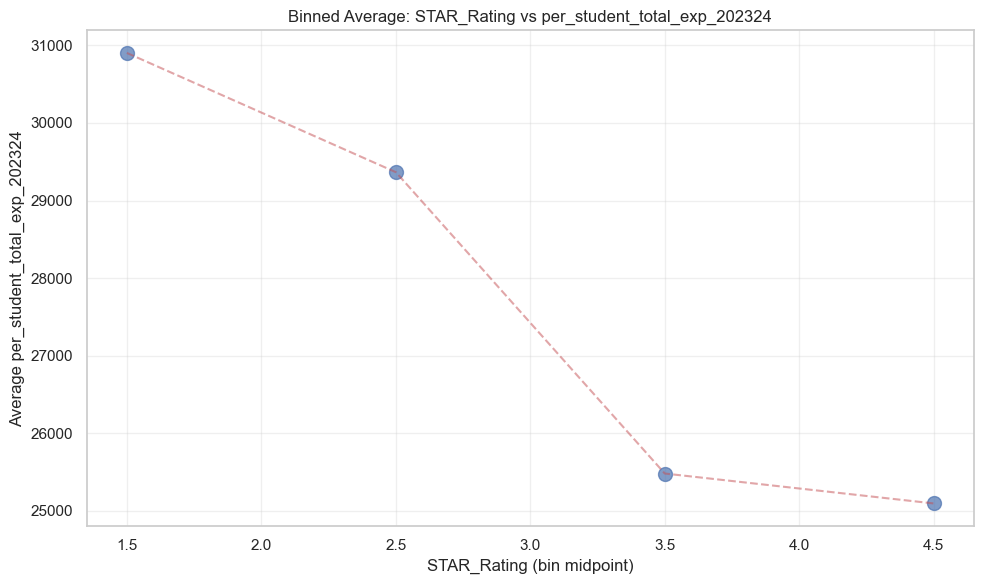

STAR_Rating: Bin averages range from 25094.42 to 30903.10


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


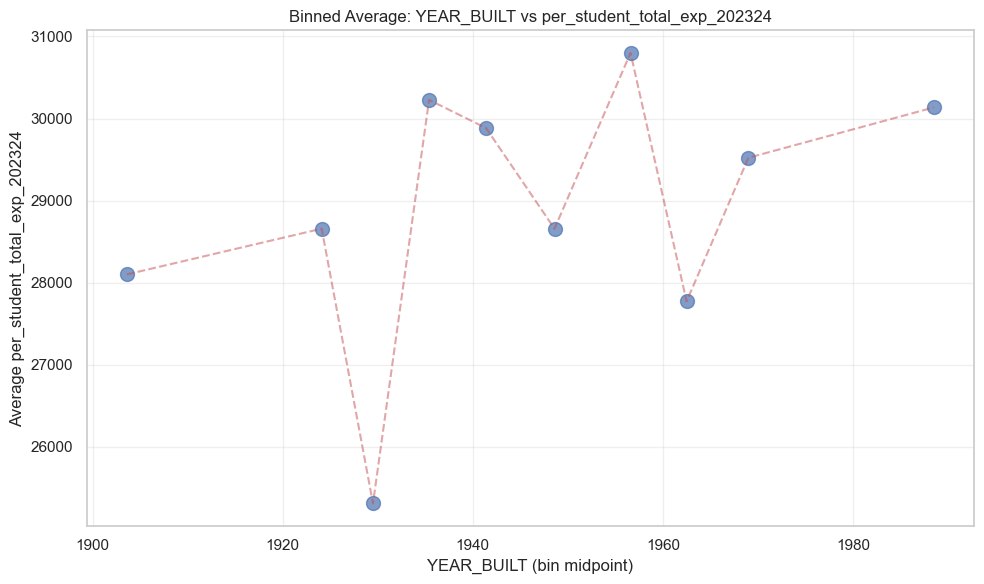

YEAR_BUILT: Bin averages range from 25311.12 to 30798.65


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


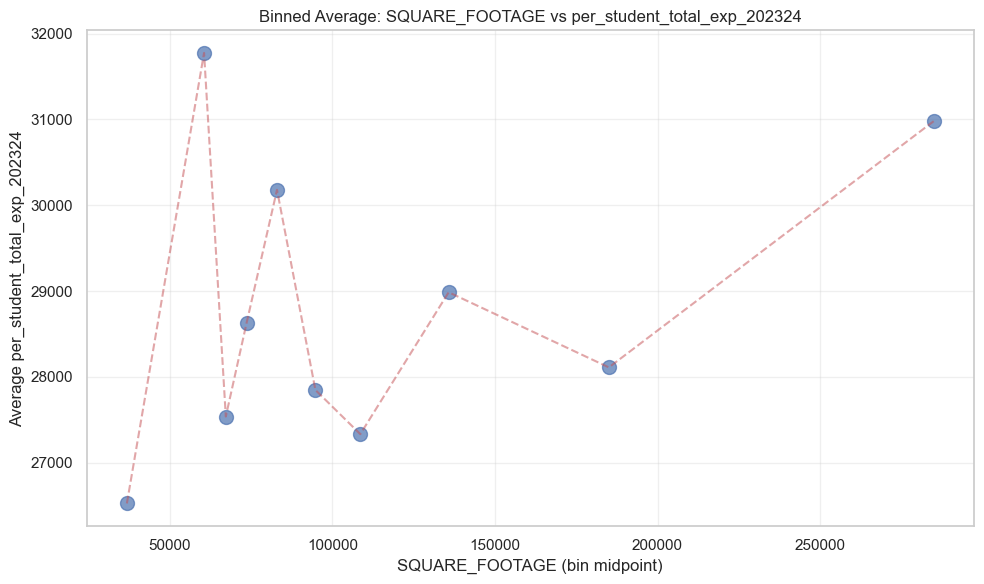

C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


SQUARE_FOOTAGE: Bin averages range from 26525.86 to 31775.11


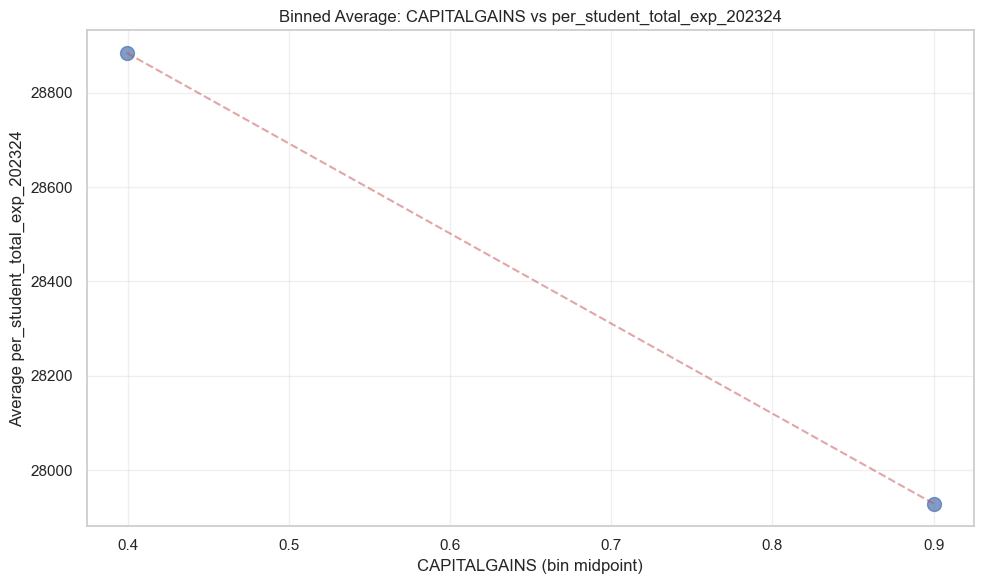

CAPITALGAINS: Bin averages range from 27928.94 to 28884.26


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


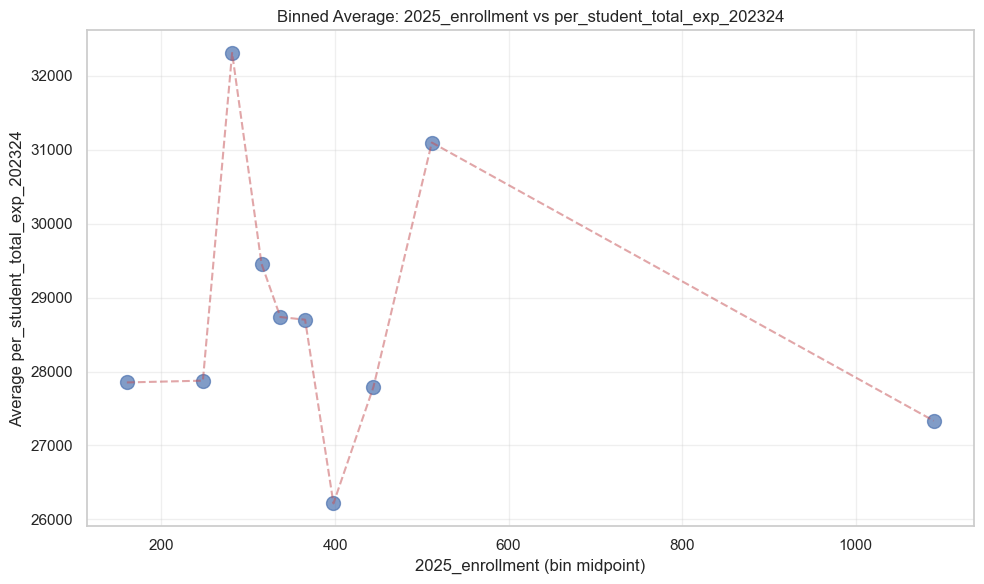

2025_enrollment: Bin averages range from 26215.51 to 32308.48


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


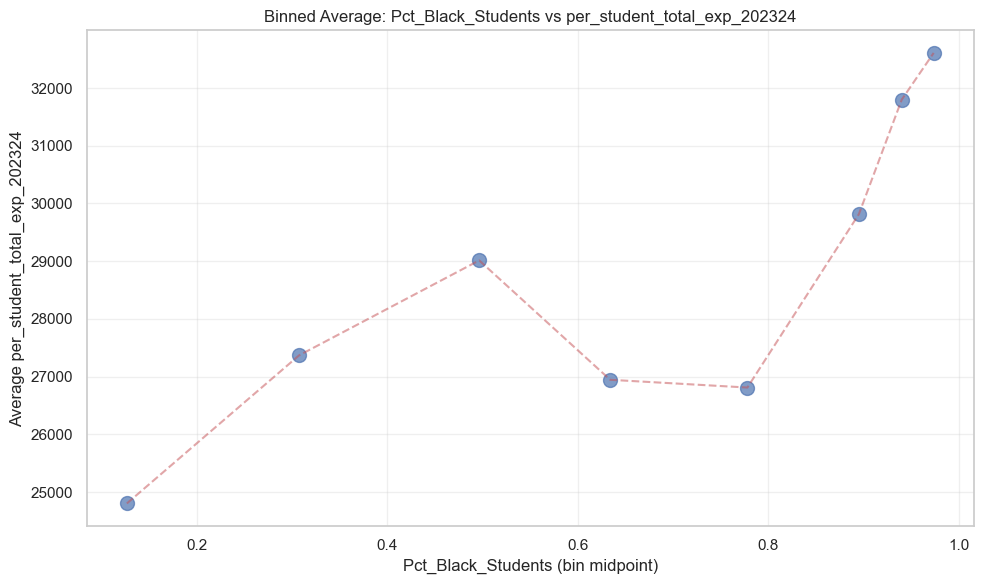

Pct_Black_Students: Bin averages range from 24803.62 to 32608.17


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


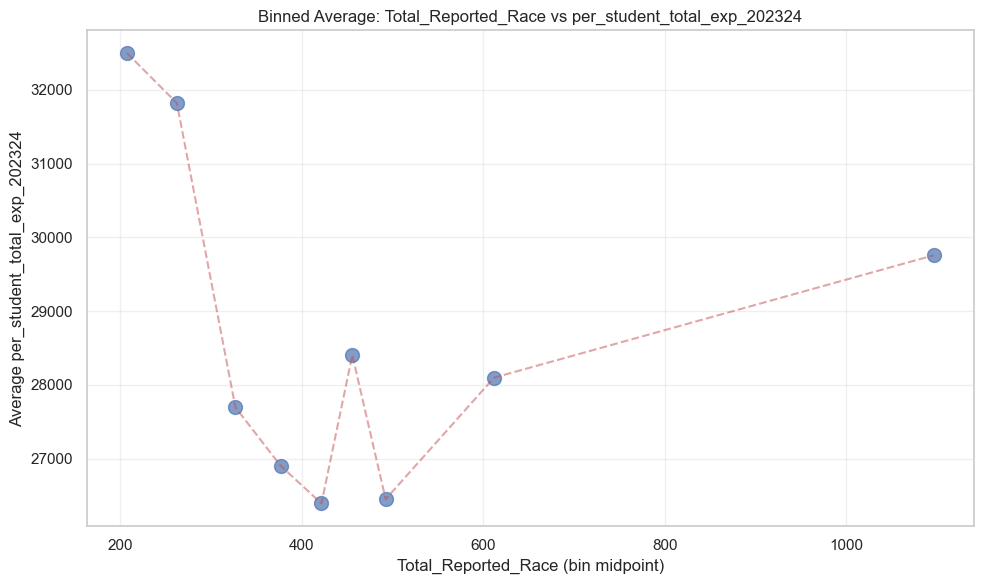

Total_Reported_Race: Bin averages range from 26392.54 to 32499.71


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


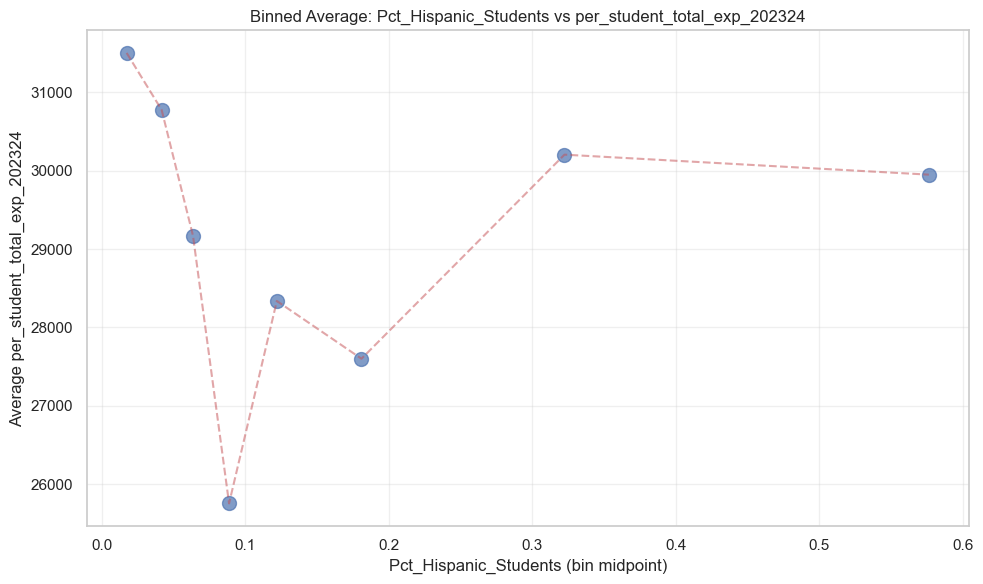

C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


Pct_Hispanic_Students: Bin averages range from 25756.55 to 31500.01


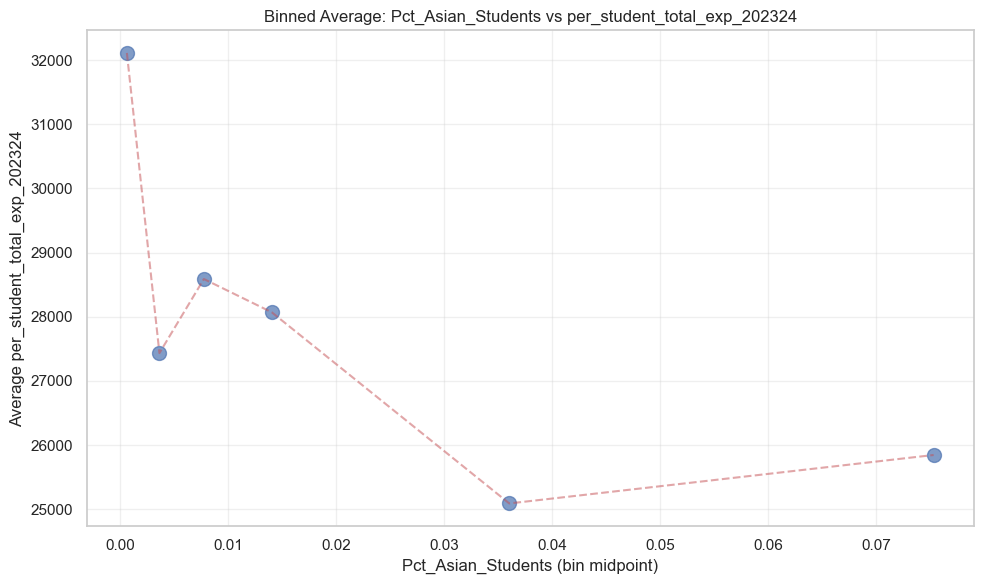

Pct_Asian_Students: Bin averages range from 25090.28 to 32112.02


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


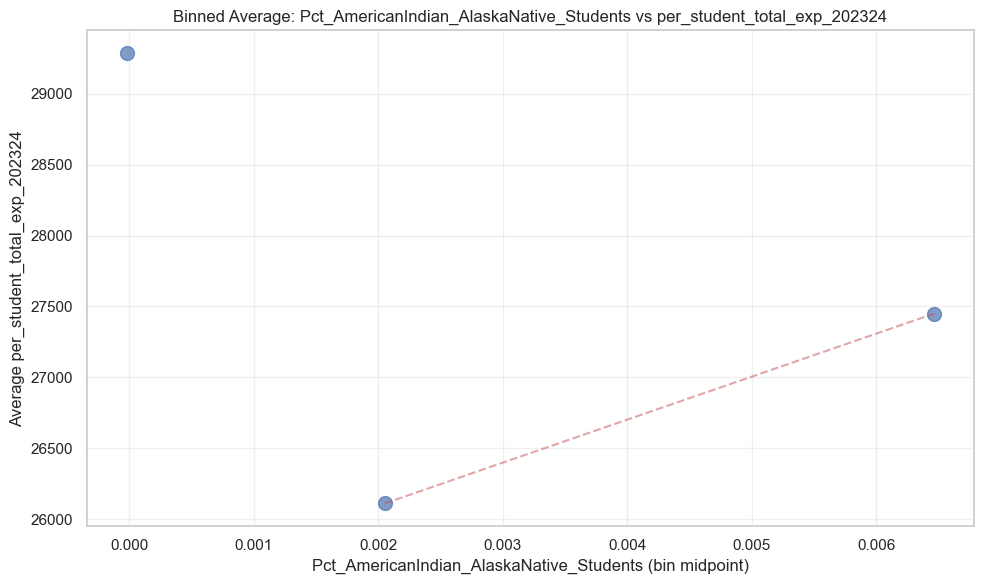

Pct_AmericanIndian_AlaskaNative_Students: Bin averages range from 26111.45 to 29286.90


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


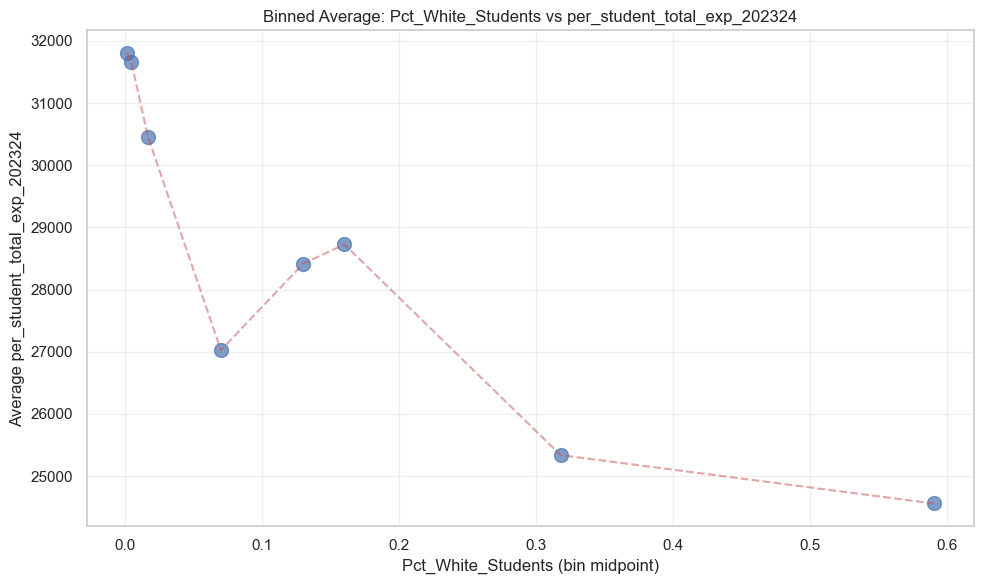

Pct_White_Students: Bin averages range from 24560.01 to 31806.24


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


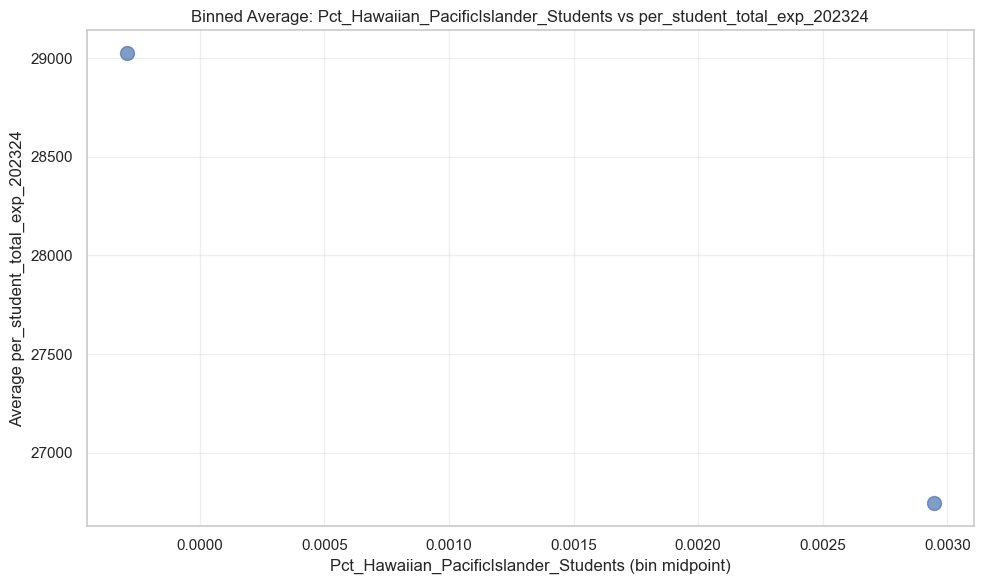

Pct_Hawaiian_PacificIslander_Students: Bin averages range from 26743.56 to 29025.99


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


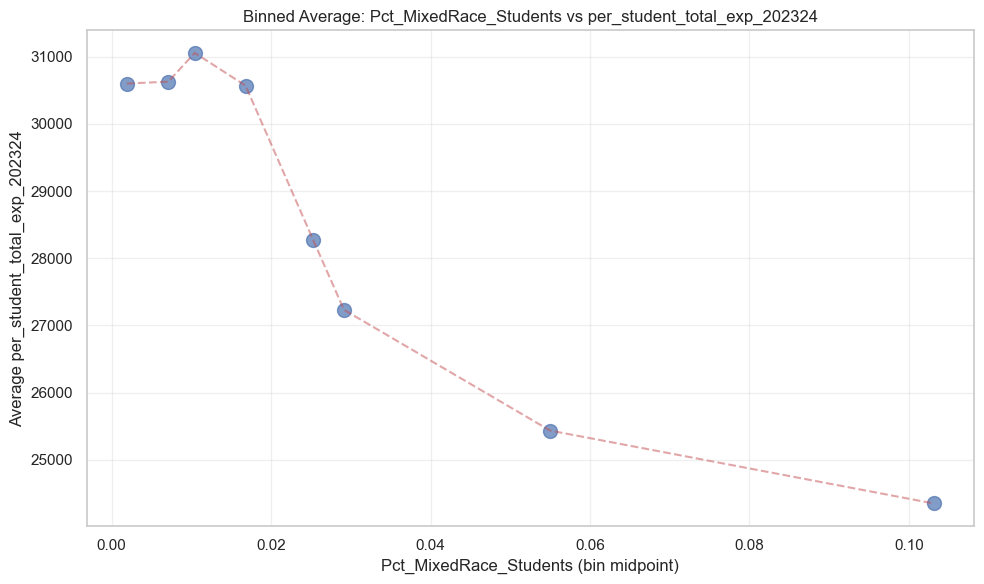

C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


Pct_MixedRace_Students: Bin averages range from 24350.30 to 31057.15


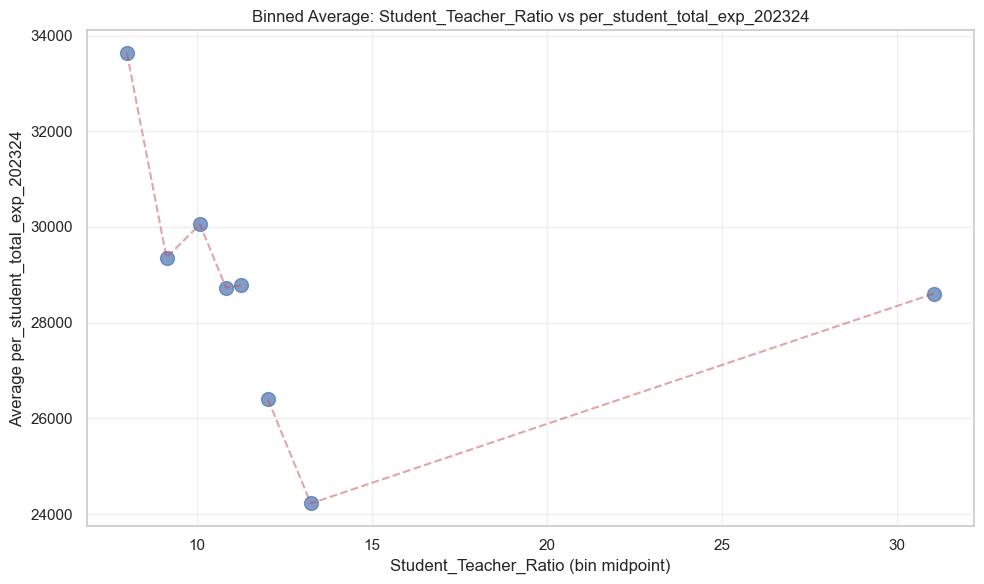

Student_Teacher_Ratio: Bin averages range from 24223.97 to 33636.85


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


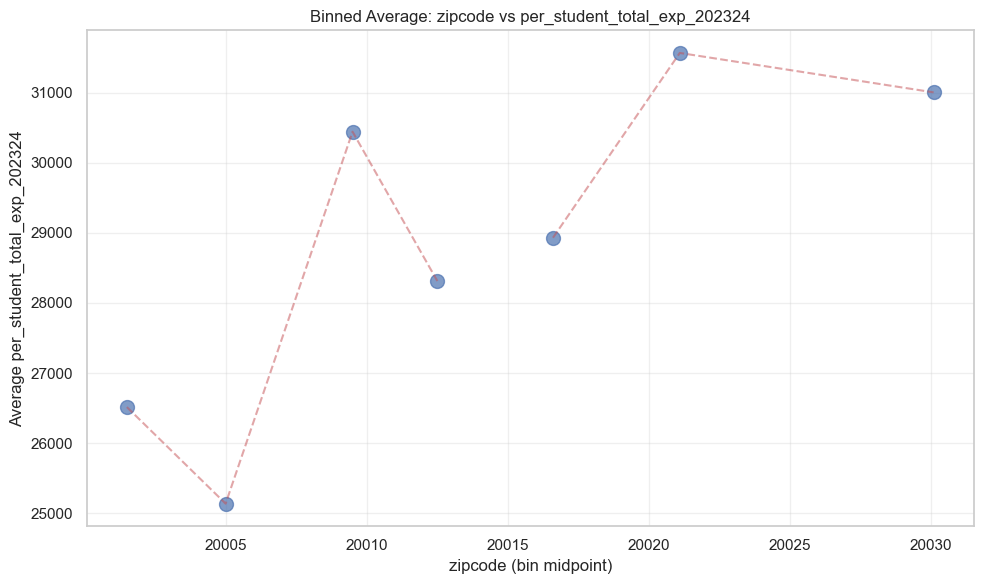

zipcode: Bin averages range from 25137.01 to 31566.94


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


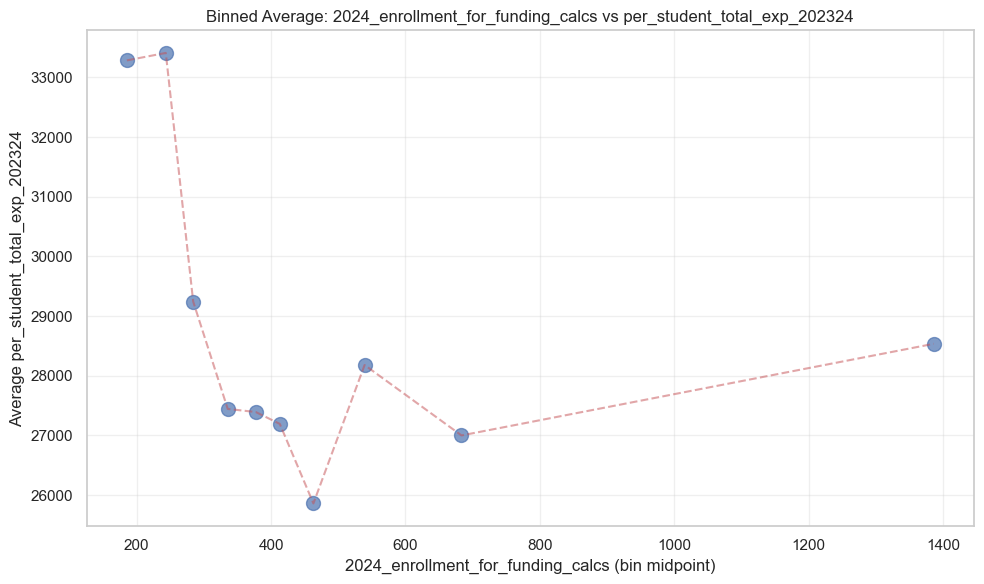

2024_enrollment_for_funding_calcs: Bin averages range from 25859.49 to 33409.37


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


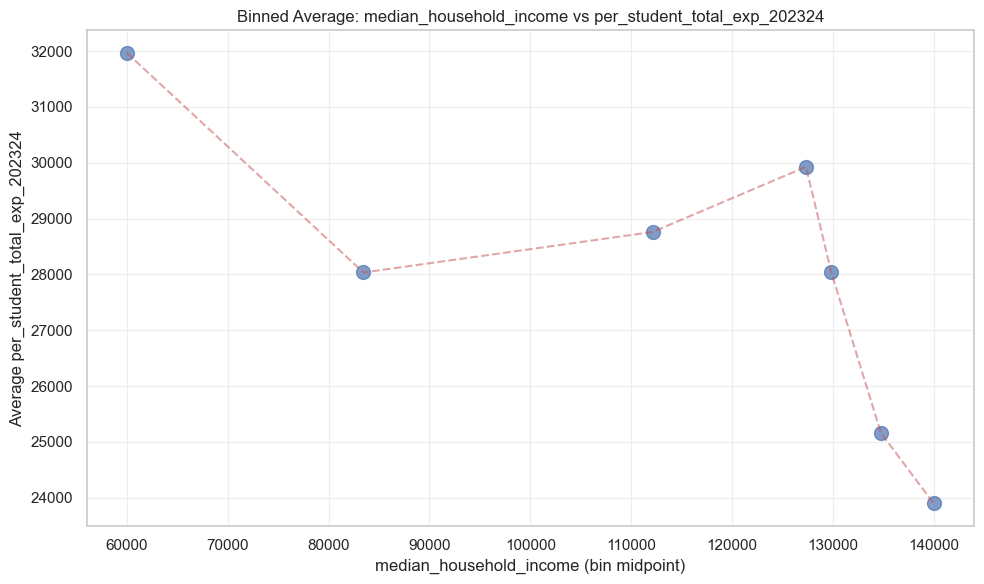

median_household_income: Bin averages range from 23899.46 to 31965.72


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


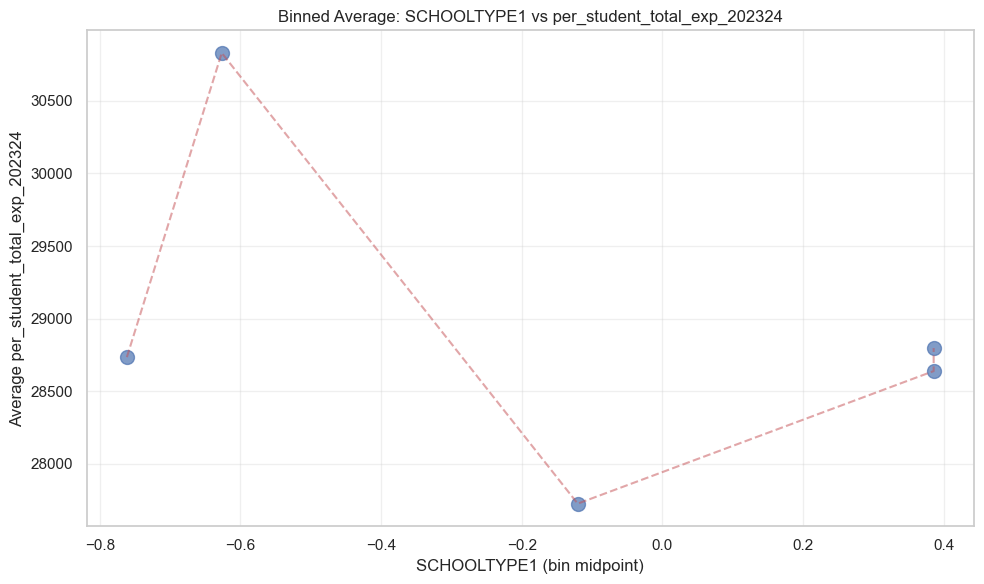

SCHOOLTYPE1: Bin averages range from 27726.41 to 30830.23


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


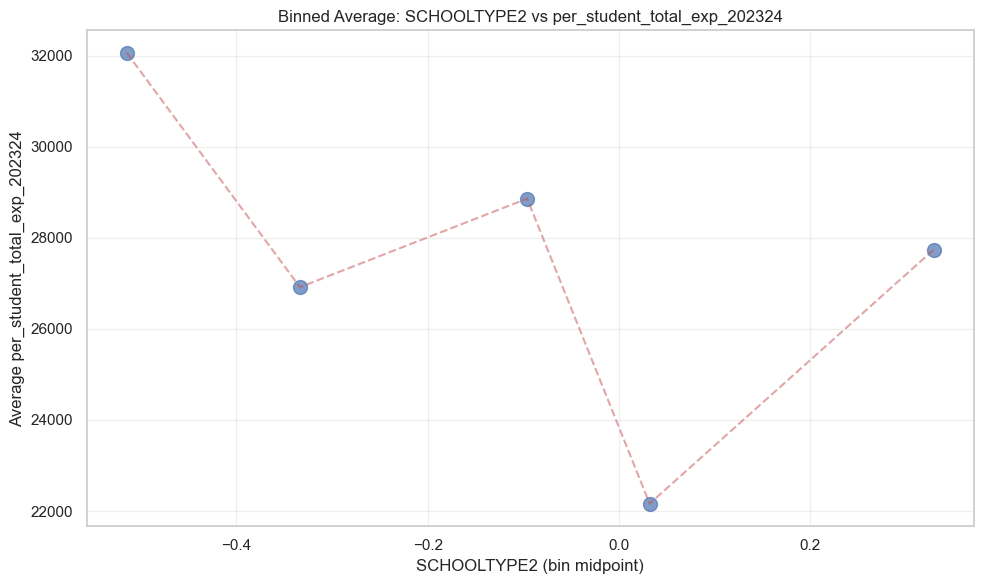

SCHOOLTYPE2: Bin averages range from 22161.99 to 32062.23


C:\Users\natha\AppData\Local\Temp\ipykernel_38056\3526735568.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(binned)[target_col].mean()


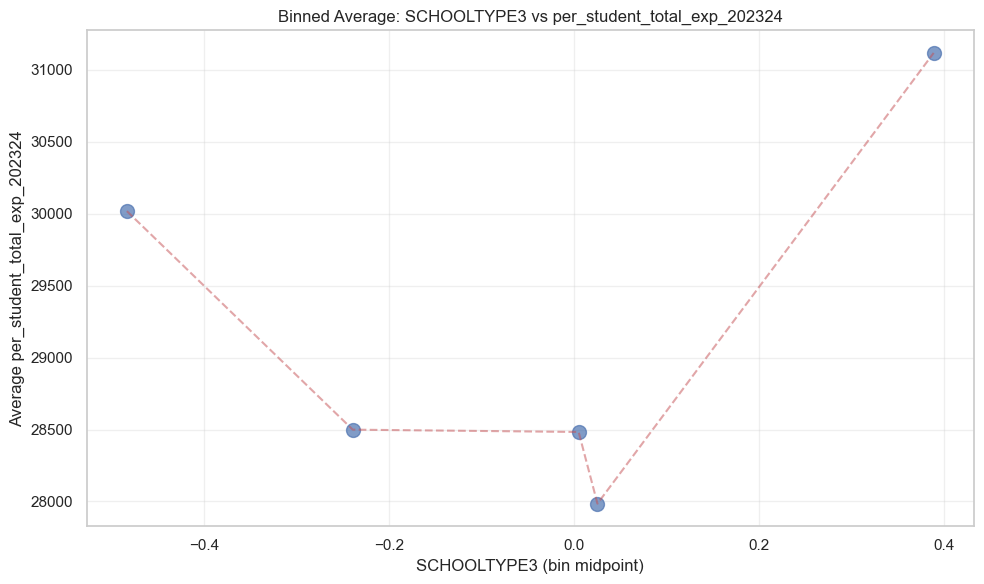

SCHOOLTYPE3: Bin averages range from 27985.02 to 31115.85

=== Categorical Features ===


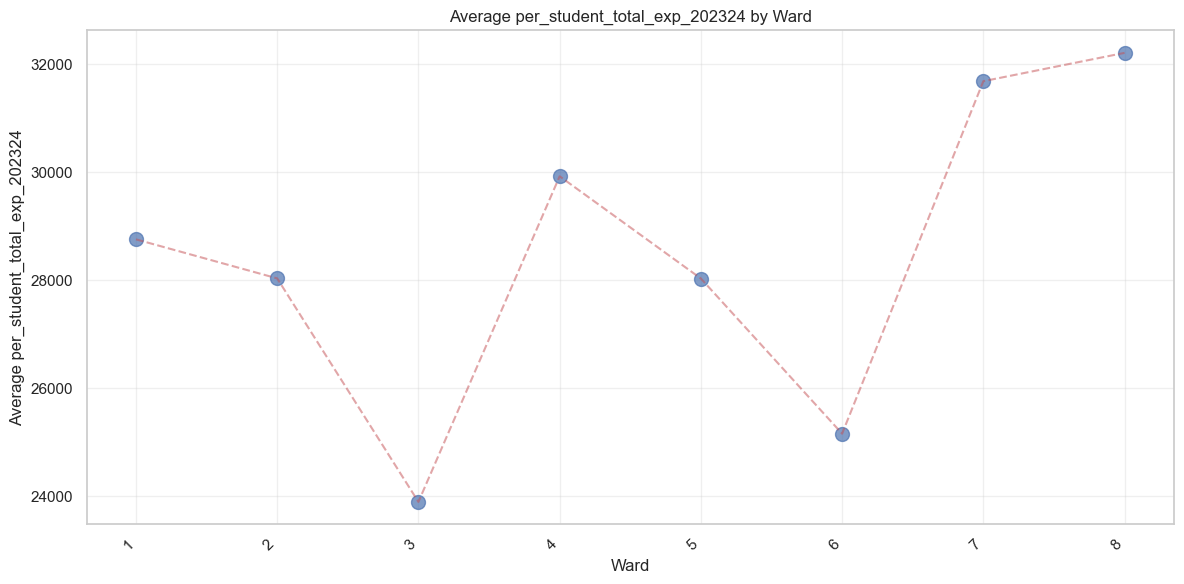

Ward: Averages range from 23899.46 to 32211.62


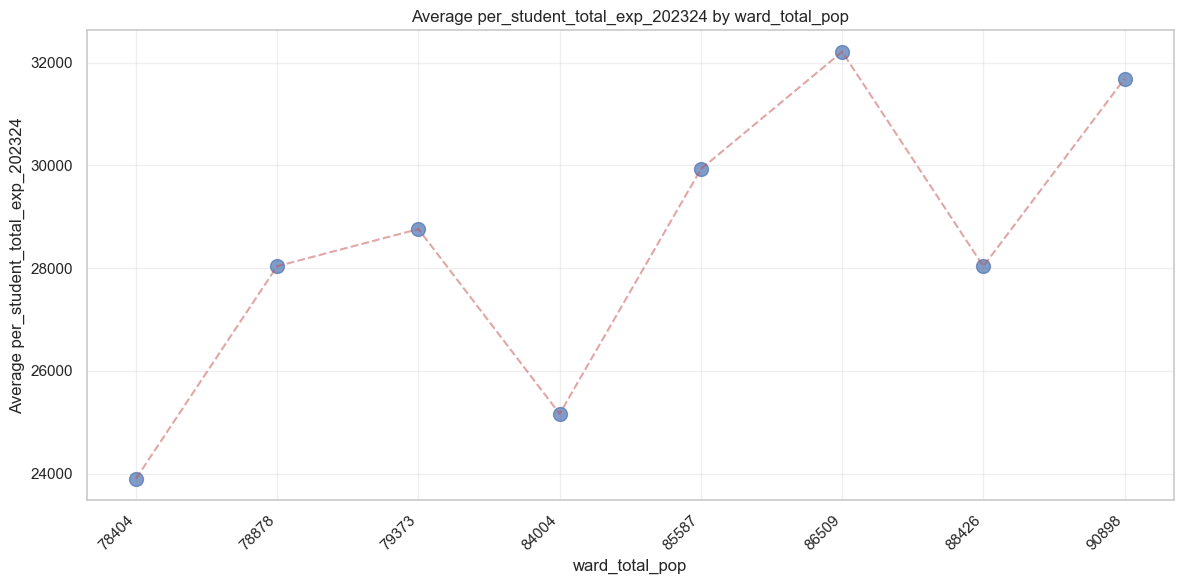

ward_total_pop: Averages range from 23899.46 to 32211.62


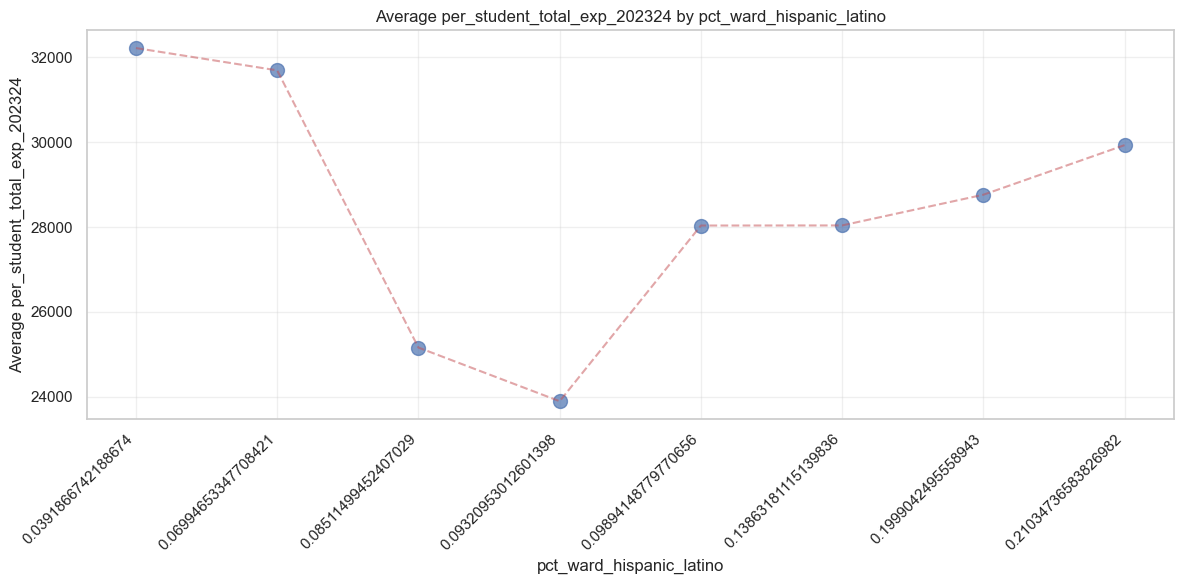

pct_ward_hispanic_latino: Averages range from 23899.46 to 32211.62


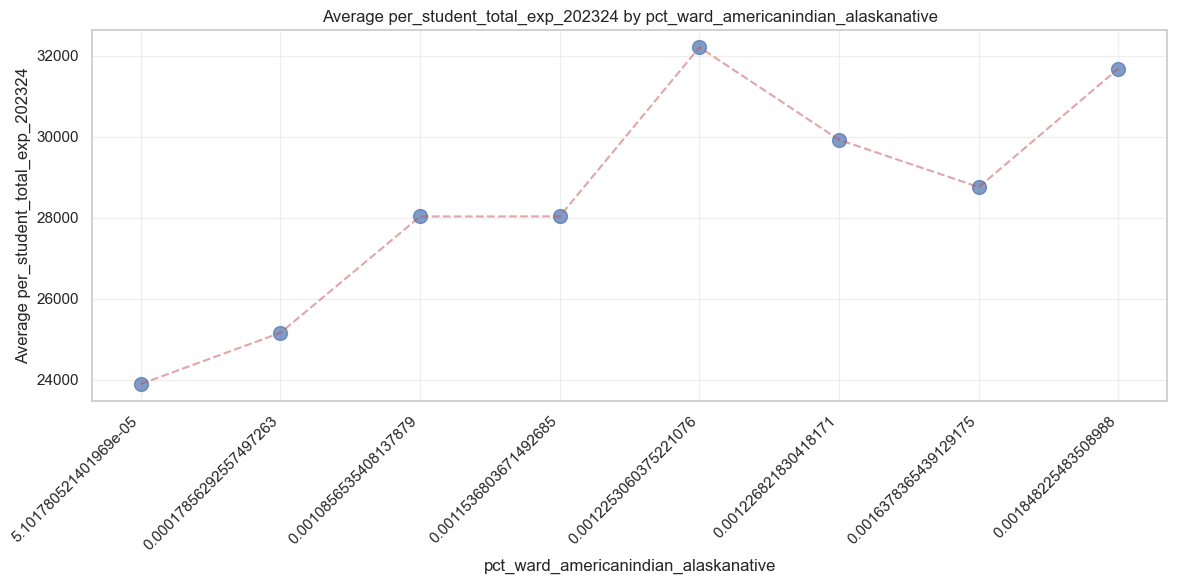

pct_ward_americanindian_alaskanative: Averages range from 23899.46 to 32211.62


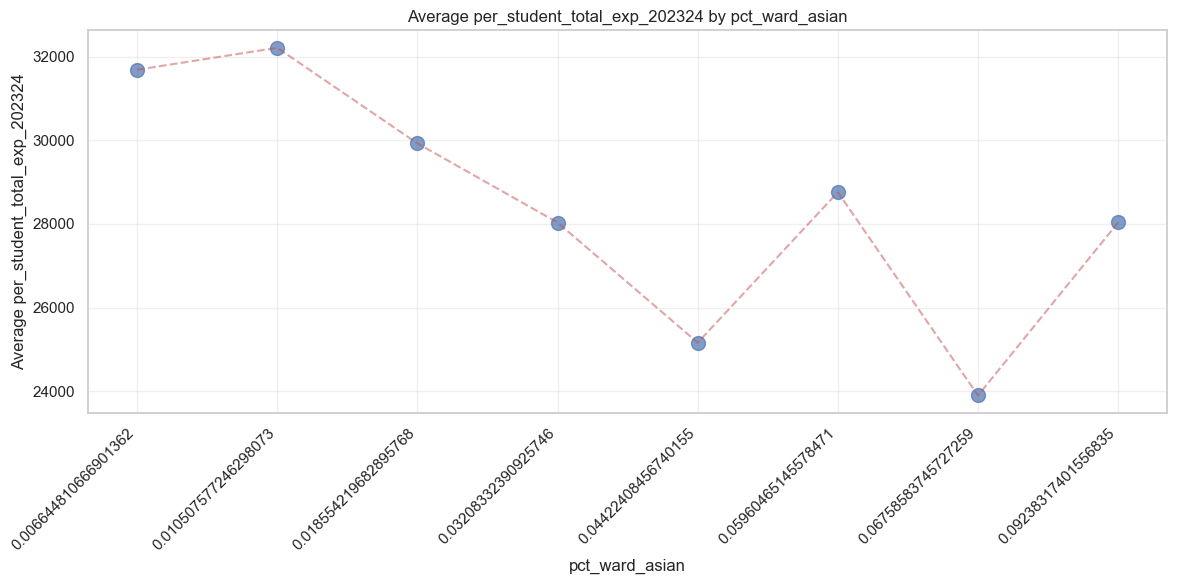

pct_ward_asian: Averages range from 23899.46 to 32211.62


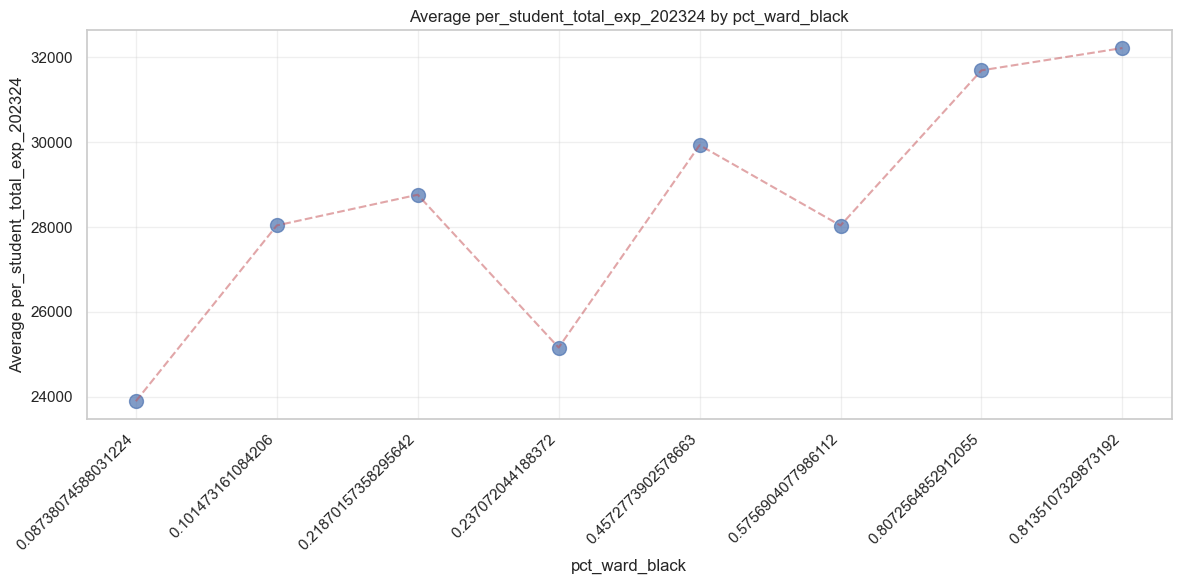

pct_ward_black: Averages range from 23899.46 to 32211.62


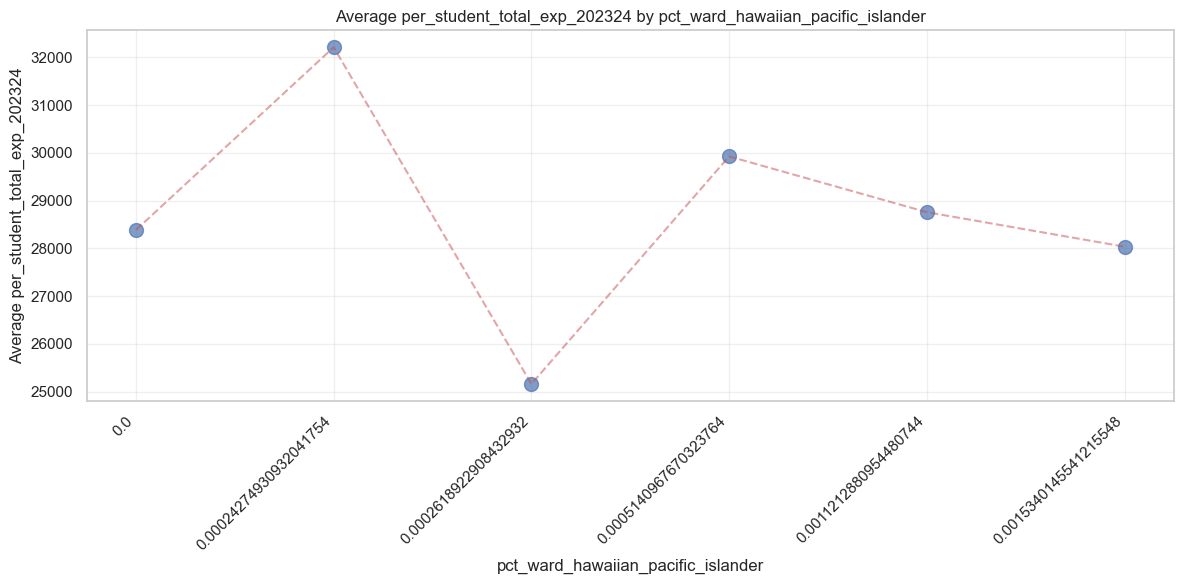

pct_ward_hawaiian_pacific_islander: Averages range from 25162.35 to 32211.62


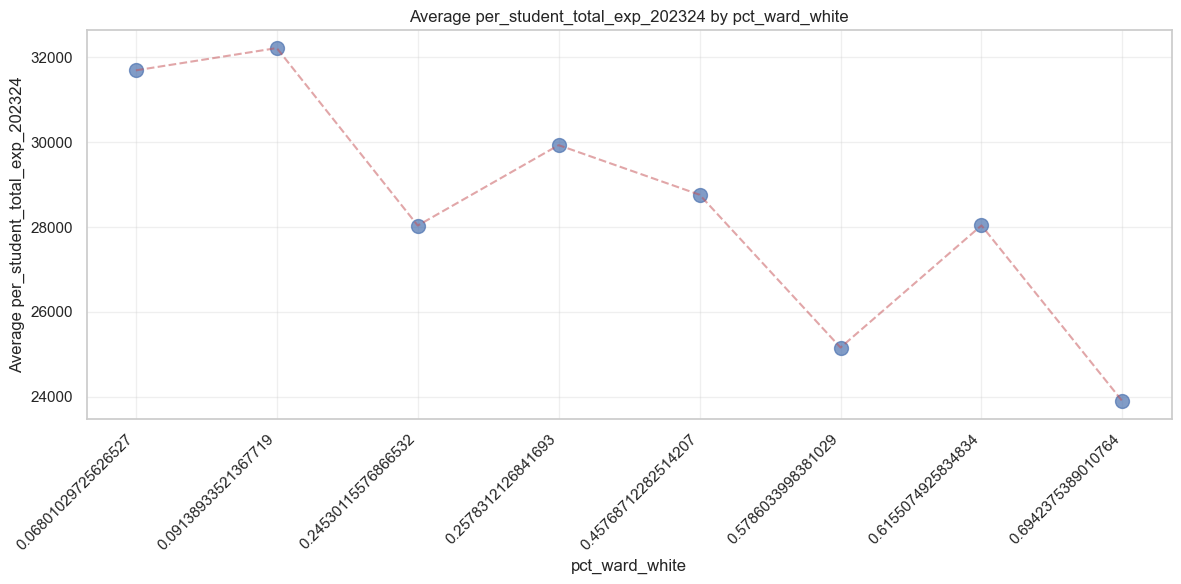

pct_ward_white: Averages range from 23899.46 to 32211.62

Done plotting binned average scatter plots.


In [ ]:

import math
sns.set_theme(style='whitegrid')

target_col = 'per_student_total_exp_202324'
all_cols = [c for c in full_data.columns if c != target_col]

numeric_cols = full_data[all_cols].select_dtypes(include=[np.number]).columns.tolist()
non_numeric = [c for c in all_cols if c not in numeric_cols]

def plot_binned_average(col, bins=5, qcut=True):
    series = full_data[col]
    y = full_data[target_col]
    
    df = pd.concat([series, y], axis=1).dropna()
    if df.shape[0] < 5:
        print(f"Skipping {col} too few non-missing observations")
        return

    if qcut:
        # use quantile binning, drop duplicate bins if column has many identical values
        binned = pd.qcut(df[col], q=bins, duplicates='drop')
    else:
        binned = pd.cut(df[col], bins=bins)

    # Calculate average target value per bin
    bin_avg = df.groupby(binned)[target_col].mean()
    bin_midpoints = [interval.mid for interval in bin_avg.index]
    
    plt.figure(figsize=(10,6))
    plt.scatter(bin_midpoints, bin_avg.values, s=100, alpha=0.7)
    plt.plot(bin_midpoints, bin_avg.values, 'r--', alpha=0.5)
    plt.title(f"Binned Average: {col} vs {target_col}")
    plt.xlabel(f"{col} (bin midpoint)")
    plt.ylabel(f"Average {target_col}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

        
# Plot numeric columns 
for col in numeric_cols:
    plot_binned_average(col, bins=10, qcut=True)

#Plot non numeric
for col in non_numeric:

    nunique = full_data[col].nunique(dropna=True)
    if nunique == 0:
        continue
    
    if nunique <= 20:
        df = full_data[[col, target_col]].dropna()
        
        # Calculate average target per category
        cat_avg = df.groupby(col)[target_col].mean().sort_index()
        
        plt.figure(figsize=(12,6))
        plt.scatter(range(len(cat_avg)), cat_avg.values, s=100, alpha=0.7)
        plt.plot(range(len(cat_avg)), cat_avg.values, 'r--', alpha=0.5)
        plt.xticks(range(len(cat_avg)), cat_avg.index, rotation=45, ha='right')
        plt.title(f"Average {target_col} by {col}")
        plt.xlabel(col)
        plt.ylabel(f"Average {target_col}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        continue

